# Introduction

## Business understanding

There are many questions we can ask about how to better utilize Airbnb, both as a host and as a traveler. Here I will focus on the situation where I'm a host in Chicago - a purely hypothetical situation, though if I moved to Chicago someday I would consider it.

As a prospective host, I would want to know how to price my property so that it's in line with prices for comparable properties. I would want to know what factors help and hurt the price the most, so that I could try to buy a property that could command higher prices on Airbnb. I probably wouldn't want to list my place all the time (since I would live there most of the time), so I would want to know at which times I can rent at the best price, and in which neighborhoods these price swings are the largest (so I could consider buying in one of those neighborhoods). I would also want to know something about the character of each neighborhood, as there are a lot of neighborhoods in Chicago I'm not very familiar with.

To get insight into these issues, here are some concrete business questions to answer:

### Question 1

What factors contribute most heavily to the price? 

Make a model to predict the price - one that's easily interpretable and perhaps one that's not as interpretable but does a better job of price prediction.

### Question 2

Which neighborhoods have the most variability in their listing prices over the course of the year? What times of year fetch the highest prices in such a neighborhood?

### Question 3

What can we discern about the character of each neighborhood using the descriptions given by hosts?

## Data understanding

Import a bunch of methods that will be useful later:

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder

**Warning to user**: Training the models in the "Random forest" part of this notebook takes a while (on the order an hour on my Macbook Air). If you're running this notebook, I'd recommend skipping that section at first; the code in all the other sections runs quickly, on the order of a minute.

Import CSV files with information on individual listings and dates/prices for those listings in the upcoming year:

In [155]:
listings = pd.read_csv("listings.csv")
calendar = pd.read_csv("calendar.csv")

Definitions for many (though not all) of the fields can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896). I got the data from [Inside Airbnb](http://insideairbnb.com/get-the-data.html), specifically [here](http://data.insideairbnb.com/united-states/il/chicago/2021-10-18/data/listings.csv.gz) (for the `listings` dataframe) and [here](http://data.insideairbnb.com/united-states/il/chicago/2021-10-18/data/calendar.csv.gz) (for the `calendar` dataframe).

In [5]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2797791,https://www.airbnb.com/rooms/2797791,20211026045305,2021-10-26,Beijing Great Wall Escape,A perfect escape only 2 hours away from Beijin...,Located in a small village at the base of the ...,https://a0.muscache.com/pictures/da7d00b7-37f0...,14311129,https://www.airbnb.com/users/show/14311129,...,4.92,4.91,4.30,NaN,f,1,1,0,0,0.71
1,4990531,https://www.airbnb.com/rooms/4990531,20211026045305,2021-10-26,Monthly Discounted- Orchid's Residence Expansi...,Begin the day in the tiled rain shower and wit...,The neighborhood is very safe and full of loca...,https://a0.muscache.com/pictures/ebd3ed91-02e2...,25729513,https://www.airbnb.com/users/show/25729513,...,4.88,4.88,4.76,NaN,t,10,6,4,0,0.34
2,6801565,https://www.airbnb.com/rooms/6801565,20211026045305,2021-10-26,Zhang's courtyard,It is a big China traditional courtyard which ...,NaN,https://a0.muscache.com/pictures/2ff4d1bb-77e4...,35607486,https://www.airbnb.com/users/show/35607486,...,NaN,NaN,NaN,NaN,t,1,0,1,0,0.02
3,6862828,https://www.airbnb.com/rooms/6862828,20211026045305,2021-10-26,Simatai Great Wall Villa,"别墅小院视野开阔居高临下位于古北水镇10km外的唐家寨,小院距离因单边墙和天梯而闻名的望京楼...",唐家寨,https://a0.muscache.com/pictures/beb38a01-56e6...,22147091,https://www.airbnb.com/users/show/22147091,...,5.00,5.00,5.00,NaN,f,3,3,0,0,0.04
4,6956755,https://www.airbnb.com/rooms/6956755,20211026045305,2021-10-26,未见西山3号院团建聚会轰趴烧烤别墅小院,2021年重新装修，独立房屋、任你撒欢、有2个客厅、房顶有大露台可以烧烤、1个大厨房各种厨房...,周边景区：千灵山景区，青龙湖景区，潭柘寺景区，戒台寺景区，北宫国家森林公园，南宫温泉景区，,https://a0.muscache.com/pictures/miso/Hosting-...,36474626,https://www.airbnb.com/users/show/36474626,...,5.00,4.87,4.93,NaN,t,1,1,0,0,0.23


In [145]:
listings['last_scraped'].value_counts()

2021-10-26    4460
Name: last_scraped, dtype: int64

In [7]:
listings['neighborhood_overview'][0]

'Located in a small village at the base of the Great Wall, Jian Kou.'

In [8]:
sum(listings['neighborhood_overview'].notnull())/len(listings)

0.8628150791880437

In [9]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,26318714,2021-10-26,f,$238.00,$202.00,1,1125
1,12351683,2021-10-26,t,$239.00,$239.00,1,1125
2,12351683,2021-10-27,t,$239.00,$239.00,1,1125
3,12351683,2021-10-28,t,$239.00,$239.00,1,1125
4,12351683,2021-10-29,t,$239.00,$239.00,1,1125


The `listings` dataframe has rows that represent unique properties (i.e. listings) that are listed on Airbnb. There are 71 features for each of these properties, though for a given property, some of them may be `NA`.

There are some columns that immediately stand out to me as important for my questions above. In the `listings` dataframe, there's a `price` column that gives the nightly price (for October 18 or 19). I anticipate that the `neighbourhood_cleansed` (neighborhood where the listing is located), `property_type`, `room_type`, `accommodates`, `beds`, `bedrooms`, and `bathrooms_text` will be especially useful for Question 1 (price prediction). They relate to the neighborhood, the type of room/property (shared room, entire house, etc.), and the size of the property, all of which I expect to be especially important for the price.

The `calendar` dataframe has a list of of dates (in the `date` column) that the each property (listing) is available, along with its price for that night, given by `adjusted_price` (for hosts who choose to use it, Airbnb has a "smart pricing" algorithm that adjusts price based on anticipated demand). The properties can be matched to those in the `listings` dataframe by matching the `listing_id` in `calendar` with the `id` in `listings`. This, along with the `neighborhood_cleansed` field of the `listings` dataframe, should be all the data I need to answer Question 2 (price variability over time, by neighborhood).

In the `neighborhood_overview` column of `listings`, hosts give a description of the neighborhood in which their listing is located. Not all hosts do this, but this field does have a non-null value for about 73% of listings. Using this field and the `neighbourhood_cleansed` field, I should be able to answer Question 3 (the character of the neighborhood).

I also note that clearly some features, such as `scrape_id` and the various URLs, are not useful for any of my questions.

In [10]:
listings['amenities'][0]

'["TV", "Heating", "Kitchen", "Cooking basics", "Essentials", "Shampoo", "Wifi", "Indoor fireplace", "Microwave", "Hot water", "Stove", "Backyard", "Long term stays allowed", "Refrigerator", "Free parking on premises", "Dishes and silverware", "First aid kit", "BBQ grill", "Free street parking", "Carbon monoxide alarm"]'

In [11]:
listings['host_verifications'][0]

"['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']"

I also note that for each listing, the `amenities` column is in the format of a list of amenities for that property; I will want to change this so that each possible amenity gets its own column that has a binary value depending on whether the listing has that amenity. The `host_verifications` column is similar.

## Data preparation (initial)

There are a few data preparation tasks that are not question-specific, so I can go ahead and do them now.

Drop columns that have all `NA` values.

In [168]:
listings_na_cols = listings.columns[listings.isna().all()]
listings.drop(columns=listings_na_cols, inplace=True)
calendar.dropna(axis=1, how='all', inplace=True)

Drop rows in `listings` that have `NA` in the `price` field, and do the same for the `price` and `adjusted_price` fields in `calendar`.

In [170]:
listings.dropna(subset=['price'], inplace=True)
calendar.dropna(subset=['price', 'adjusted_price'], inplace=True)

0       False
1       False
2       False
3       False
4       False
        ...  
4478    False
4479    False
4480    False
4481    False
4482    False
Name: price, Length: 4483, dtype: bool

Observe that a dollar sign preceeds the number in several columns; I will remove this so that the field is treated as numeric.

In [171]:
listings['price'] = listings.apply((lambda x: x['price'].replace('$','').
                                    replace(',','')), axis=1)
calendar['price'] = calendar.apply((lambda x: x['price'].replace('$','')
                                    .replace(',','')), axis=1)
calendar['adjusted_price'] = calendar.apply((lambda x: x['adjusted_price']
                                             .replace('$','').replace(',','')), axis=1)

The price should be greater than zero. I'll drop all rows where this is not the case.

In [172]:
listings['price'] = listings['price'].astype(np.float64)
calendar['price'] = calendar['price'].astype(np.float64)
calendar['adjusted_price'] = calendar['adjusted_price'].astype(np.float64)

In [173]:
listings.drop(listings.loc[listings['price'] <= 0].index, inplace=True)

Similarly, some of the fields are expressed as percentages; I will remove the percent signs and change the entries to floats.

In [175]:
listings['host_response_rate'] = listings.apply(lambda x: float(x['host_response_rate'].replace('%','')) if pd.notnull(x['host_response_rate']) else x['host_response_rate'], axis=1)
listings['host_acceptance_rate'] = listings.apply(lambda x: float(x['host_acceptance_rate'].replace('%','')) if pd.notnull(x['host_acceptance_rate']) else x['host_acceptance_rate'], axis=1)

AttributeError: 'float' object has no attribute 'replace'

## A note about CRISP-DM

For each question, to keep things organized, I will follow the CRISP-DM process: Business understanding, data understanding, data preparation, modeling, evaluation, and deployment. I already showed the business and data understanding steps above, as well as part of the data preparation step. The later steps (data preparation [the parts that haven't already been done], modeling, evaluation, and deployment) have different results for each question, so I will show them within each of the following sections (Question 1, Question 2, and Question 3). I think doing it this way, i.e. addressing the following CRISP-DM steps separately for each question, makes more sense than splitting the notebook up into six sections (one for each step of CRISP-DM) and then having a subsection within each of those sections for each question. This way, I'm able to focus the narrative on each question until I've given it a satisfactory answer and deployed a solution, before interrupting the flow with the next question.

# Question 1: Price prediction

## Data preparation

Split into `X` and `y`.

In [176]:
X = listings.drop('price', axis=1)
y = listings['price']

I also need to deal with dates appropriately. The relevant columns are `host_since`, `first_review`, and `last_review`. I could scrap these columns altogether, but it might be useful to know the length of time since the date for each row. 

In [178]:
for col in ['host_since', 'first_review', 'last_review']:
    X[col] = pd.to_datetime(X['last_scraped']) - pd.to_datetime(X[col])
    X[col] = X.apply(lambda x: x[col].days, axis=1)

Certain columns in `X` are not useful for prediction (for example, URLs), and should be removed.

In [179]:
to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']
to_drop += ['description', 'neighborhood_overview', 'picture_url', 'host_id']
to_drop += ['host_url', 'host_name', 'host_about', 'host_thumbnail_url']
#to_drop += ['host_picture_url', 'license', 'calendar_last_scraped']
to_drop += ['host_picture_url', 'calendar_last_scraped']
X.drop(labels=to_drop, axis=1, inplace=True)

Certain columns (`host_verifications` and `amenities`) are lists of options; I'd like to split these into different columns.

The first step is to change these entries into actual Python lists instead of strings (annoyingly, the two relevant columns are formatted slightly differently, with the roles of single and double quotes being interchanged between them).

In [180]:
X['host_verifications'] = X.apply(lambda x: x['host_verifications'].replace('[','').replace(']','').replace('\'','').split(', '), axis=1)

In [181]:
X['amenities'] = X.apply(lambda x: x['amenities'].replace('\"','').replace('[','').replace(']','').split(', '), axis=1)

What are the possible values in the `host_verifications` lists?

In [23]:
distinct_host_verifications = set()
def find_distinct_hvs(x):
    ''' INPUTS: x - a row of the `listings` dataframe.
        OUTPUTS: none. For each element of the list x['host_verifications'],
                 the element is added to the distinct_host_verifications set.
    '''
    for hv in x['host_verifications']:
        distinct_host_verifications.add(hv)
X.apply(lambda x: find_distinct_hvs(x), axis=1)
distinct_host_verifications = list(distinct_host_verifications)

In [182]:
len(distinct_host_verifications)

16

The `MultiLabelBinarizer` in `sklearn` works for splitting the lists into their individual elements, and then creating a dummy variable for each one (I started to write this myself, and then found that this convenient function exists in sklearn!).

In [183]:
from sklearn.preprocessing import MultiLabelBinarizer

Instantiate the binarizer and it to create binary columns for the `host_verification` options:

In [184]:
mlb_hv = MultiLabelBinarizer()
hv_df = pd.DataFrame(mlb_hv.fit_transform(X['host_verifications']),
                     columns=mlb_hv.classes_, index=X.index)

Concatenate these columns to the original dataframe:

In [186]:
X = pd.concat([X, hv_df], axis=1)

Rename the column labeled 'None':

In [187]:
X.rename(columns={'None' : 'HV_None'}, inplace=True)
# I don't want a column to be called just 'None', so I changed it a bit

Now I can drop the original `host_verifications` column.

In [188]:
X.drop('host_verifications', axis=1, inplace=True)

Now I'd like to do the same for the `amenities` column. What are the possible values in those lists, and how many are there?

In [189]:
distinct_amenities = set()
def find_distinct_amenities(x):
    ''' INPUTS: x - a row of the `listings` dataframe.
        OUTPUTS: none. For each element of the list x['amenities'],
                 the element is added to the set distinct_amenitites.
    '''
    for a in x['amenities']:
        distinct_amenities.add(a)
X.apply(lambda x: find_distinct_amenities(x), axis=1)
len(distinct_amenities)

143

Ok, that's a lot of amenities. I don't really want to vastly blow up the number of features like this, so I'll just take the 20 most popular amenities.

In [190]:
from collections import defaultdict
from operator import itemgetter

In [191]:
amenity_counts = defaultdict(int) # Initializes to zero for each value
def update_counts(x):
    ''' INPUTS: x - a row of the `listings` dataframe.
        OUTPUTS: none. For each element `a` of the list x['amenities'], the element
                 amenity_counts[a] of the amenity_counts dictionary is incremented by 1.
    '''
    for a in x['amenities']:
        amenity_counts[a] += 1
X.apply(lambda x: update_counts(x), axis=1);

Make a list with the top 20 amenities and their counts:

In [192]:
top_20 = sorted(amenity_counts.items(), key=itemgetter(1), reverse=True)[:20]

In [194]:
top_20[:5]

[('Wifi', 4417),
 ('Shampoo', 4324),
 ('Hair dryer', 4313),
 ('Long term stays allowed', 4263),
 ('Air conditioning', 4246)]

Make a list with just those amenities:

In [195]:
top_20_amenities = list(dict(top_20).keys())

Now I want to get rid of the other amenities in each row.

In [196]:
def find_amenities(x):
    ''' INPUTS: x - a row of the `listings` dataframe.
        OUTPUTS: amenities - a list of amenities in the row that are in the top 20
                 amenities.
    '''
    amenities = []
    for a in top_20_amenities:
        if a in x['amenities']:
            amenities.append(a)
    return amenities

Apply `find_amenities()` to each row:

In [197]:
X['amenities'] = X.apply(lambda x: find_amenities(x), axis=1)

Now I can create the dummy variables and drop the original `amenities` column.

In [198]:
mlb_amenities = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb_amenities.fit_transform(X['amenities']),
                            columns=mlb_amenities.classes_, 
                            index=X.index)
X = pd.concat([X, amenities_df], axis=1)
X.drop('amenities', axis=1, inplace=True)

Next, I'll get dummies for the rest of the categorical variables.

A note: The Pandas `get_dummies()` method has the huge disadvantage that it can't be applied to new data; given a new instance I want to transform to be in the same format as the rows of X, I would have to append this to the end of `listings` and then do all the transformations for preparation again to the whole of X, which is horribly inefficient. Thankfully, sklearn's `OneHotEncoder` doesn't suffer from this shortcoming; it can be fit to X and used to transform any new data that comes in later for predictions.

I didn't realize this disadvantage until I tried to implement a data preparation pipeline at the end (for deployment).

Find the categorical variables:

In [201]:
X_cat = X.select_dtypes(include='object').copy()
cat_columns = X_cat.columns

Replace the `NA` values with the string "NA":

In [202]:
X_cat.fillna(value="NA", inplace=True)

I'm chooing to replace nan values with "NA" in the categorical columns for a rather odd reason having to do with the application of sklearn's `OneHotEncoder`. It worked fine for me here; I can verify that the nan values in this dataframe are `np.nan` by using `value is np.nan` to check whether `value` is `np.nan`. But when I tried to apply it in my data preparation pipeline at the end (for deployment) using my `my_listing.csv` file, it gave me an error, saying "ufunc 'isnan' not supported for the input types." Testing a field there in the same way, I found that it was not `np.nan`, and even when I set it explicitly equal to `np.nan`, it still would not return `True` to `value is np.nan`! This is a weird implementation issue, it appears: `id(np.nan)` gives 4547092880 whereas the `id` of the nan value in question gave 5781442624 (I checked that this is not equal to `id(math.nan)` or `id(float('nan'))`). Quite annoying! I couldn't figure out how to set this pointer explicitly - I'm not sure that's something I can do without getting into ctypes. So I'm just going to replace nan values for these columns with the string 'NA', which will then be turned into its own category for each categorical column by `OneHotEncoder`. That is, for each categorical variable, 'NA' is treated as its own category by the encoder.

Create a one-hot encoder (note `sparse=False` is required for this to play nice with the `pd.DataFrame()` method):

In [203]:
one_hot = OneHotEncoder(dtype=np.int64, sparse=False)
one_hot

OneHotEncoder(dtype=<class 'numpy.int64'>, sparse=False)

Use the one-hot encoder to transform the categorical variables and convert to a dataframe:

In [204]:
X_onehot = pd.DataFrame(one_hot.fit_transform(X_cat),
                        columns=one_hot.get_feature_names_out(),
                        index = X.index)

Drop the original categorical columns:

In [205]:
X.drop(columns=cat_columns, inplace=True)

Concatenate the one-hot columns to the original dataframe:

In [206]:
X = pd.concat([X, X_onehot], axis=1)

I need to deal with `NA` values for the numeric columns. There's no totally ideal way to do this, but to move forward I'll impute using the mean. It wouldn't make sense to simply drop instances that have an `NA` value (or a few); there are dozens of features, and lots of hosts have not taken the time to fill them all in but still filled in enough information to make reasonable models.

Impute using mean values:

In [207]:
fill_mean = lambda col: col.fillna(col.mean())
X = X.apply(fill_mean)

In [208]:
# Keep the column means for later
X_col_means = X.mean(axis=0)

## Modeling and preliminary evaluation (with visualizations)

I will try a variety of different models for price prediction. In the course of tuning model parameters, I am also doing some evaluation of the model via cross-validation. In the next section (Final evaluation and deployment), I do my final evaluations on the test set for each model.

Split into train and test sets.

In [209]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Now, don't touch the test set until the end (use cross-validation to evaluate models before then). I don't want to bias myself by picking up patterns in the test set.

It will be useful for me to have a validation set (e.g. for plotting results to get a handle on what's going on) that I can access explicitly, instead of just the ones that `cross_val_score` uses in the course of its execution.

In [210]:
X_val_train, X_val, y_val_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

### Linear model

Instantiate the model, including normalization in the pipeline via `StandardScaler`:

In [211]:
pipe = make_pipeline(StandardScaler(), LinearRegression())

Use cross-validation to get $R^2$ scores for the model on the training set:

In [212]:
scores = cross_val_score(pipe, X, y)
print("Scores:")
print(scores)
print(f"Mean = {scores.mean():.3g}, Standard Error = {scores.std()/np.sqrt(5):.3g}")

Scores:
[-4.93124873e+24 -8.17515243e+25 -2.54562209e+26 -7.12268769e+24
 -4.83517612e+23]
Mean = -6.98e+25, Standard Error = 4.35e+25


This looks pretty bad. I'll use my validation set from above to take a closer look.

Fit the model to the training set with validation set removed, and then score the model on the validation set:

In [213]:
pipe.fit(X_val_train, y_val_train)
pipe.score(X_val, y_val)

-8.821241509639502e+24

Still quite poor, as expected.

Get the predictions on the validation set:

In [214]:
y_pred = pipe.predict(X_val)

Plot the absolute error of the predictions:

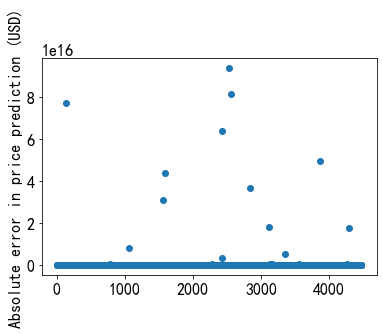

In [215]:
plt.plot(np.abs(y_val - y_pred), 'o')
plt.ylabel('Absolute error in price prediction (USD)')
plt.show()

Clearly some of the predictions are enormous and completely unreasonable. I think I need to aggressively get rid of features to correct this - I have way too many categorical variables that don't occur often and are not very relevant to price prediction.

Here are some functions to do this conveniently, as well as evaluate models using cross-validation.

In [216]:
def do_cutoff(X, cutoff):
    ''' INPUTS: X - input dataframe with instances as rows and features as columns.
               cutoff - a cutoff for which features to include. Features for which the 
                        average absolute value over all samples is below the cutoff are
                        excluded. Can be a number or `False`, in which case no features
                        are removed. Thanks to Udacity's data science course for suggesting
                        this strategy to cut down on the number of categorical features.
        OUTPUTS: X_cutoff - the input dataframe with features removed (via the cutoff).
    '''
    X_cutoff = X.iloc[:, np.where(np.abs(X.sum()/len(X)) > cutoff)[0]]
    return X_cutoff

In [217]:
def fit_model(X, y, model, cutoff=False, return_X_cutoff=False):
    ''' Fits the model given and evaluates it on the input data using cross-validation.
    INPUTS: X - input dataframe with instances as rows and features as columns.
            y - targets (a dataframe or series); in this part, a price for each instance.
            model - the model to be used; for example, `LinearRegression()`.
            cutoff - a cutoff for which features to include. Features for which the average
                    absolute value over all samples is below the cutoff are excluded.
                    Can be a number or `False`, in which case no features are removed.
            return_X_cutoff - a boolean parameter that determines whether to return
                              the input dataframe with features removed (via the cutoff).
    OUTPUTS: y_pred - an array of predictions (using cross-validation) for each instance.
             X_cutoff - the input dataframe with features removed (via the cutoff).
                        Only returned if return_X_cutoff=True.
    '''
    pipe = make_pipeline(StandardScaler(), model)
    if cutoff is False:
        cutoff = -1
    # Only keep features for which the average absolute value
    # over all samples exceeds some cutoff
    X_cutoff = do_cutoff(X, cutoff)
    y_pred = cross_val_predict(pipe, X_cutoff, y)
    if return_X_cutoff:
        return y_pred, X_cutoff
    else:
        return y_pred

In [218]:
def score_model(X, y, model, cutoff, return_n_features=False, scoring=None):
    ''' Evaluates `model` on X, y using cross-validation and a scoring function.
    If `scoring=None` then the scoring function in sklearn's implementation of 
    `model` is used.
    Optionally, the number of features in the training set can be returned.
    This is done if return_n_features=True.
    INPUTS: X - input dataframe with instances as rows and features as columns.
            y - targets (a dataframe or series); in this part, a price for each instance.
            model - the model to be used; for example, `LinearRegression()`.
            cutoff - a cutoff for which features to include. Features for which the average
                    absolute value over all samples is below the cutoff are excluded.
                    Can be a number or `False`, in which case no features are removed.
            return_n_features - a boolean that returns the number of features in X_cutoff
                               if set to True.
            scoring - a scoring function to be used for evaluating the prediction accuracy.
                      If set to None, then the scoring function in `model` is used.
    OUTPUTS: scores - an array of scores for the predictions.
             n_features - the number of features used for the model (i.e., the number
                          of features in X_cutoff).
    '''
    pipe = make_pipeline(StandardScaler(), model)
    X_cutoff = do_cutoff(X, cutoff)
    n_features = X_cutoff.shape[1]
    scores = cross_val_score(pipe, X_cutoff, y, scoring=scoring)
    if return_n_features:
        return scores, n_features
    else:
        return scores

In [222]:
def test_cutoffs(X, y, model, cutoffs, scoring=None, print_results=True):
    ''' Loops through different cutoffs on the number of features.
    INPUTS: X - input dataframe with instances as rows and features as columns.
            y - targets (a dataframe or series); in this part, a price for each instance.
            model - the model to be used; for example, `LinearRegression()`.
            cutoffs - a list of cutoffs to use. For each cutoff, features for which
                    the average absolute value over all samples is below the cutoff
                    are excluded. Can be a number or `False`, in which case no features
                    are removed.
            scoring - a scoring function to be used for evaluating the prediction accuracy.
                      If set to None, then the scoring function in `model` is used.
            print_results - a boolean that determines whether to print results of model
                            evaluation. If True, then the cutoff, mean score, and standard
                            error of the mean score, and number of features used is 
                            printed for each cutoff in `cutoffs`.
    OUTPUTS: scores - an array of scores for the predictions.
             n_features - the number of features used for the model (i.e., the number
                          of features in X_cutoff).
    '''
    results = {}
    for cutoff in cutoffs:
        scores, n_features = score_model(X, y, model, cutoff, return_n_features=True,
                                         scoring=scoring)
        if print_results:
            print(f"Cutoff = {cutoff:.3g}, Mean score = {scores.mean():.3g}, Standard error = {scores.std()/np.sqrt(5):.3g}, n_features = {n_features}")
    return scores

Now I can use my `test_cutoffs` function to fit the model to training data that has had its number of features shrunk using a list of cutoffs:

In [223]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs);

Cutoff = 1e+03, Mean score = -0.00372, Standard error = 0.00176, n_features = 3
Cutoff = 1, Mean score = 0.469, Standard error = 0.0159, n_features = 36
Cutoff = 0.9, Mean score = -1.23e+15, Standard error = 1.1e+15, n_features = 48
Cutoff = 0.7, Mean score = -3.24e+12, Standard error = 2.89e+12, n_features = 58
Cutoff = 0.3, Mean score = -1.89e+20, Standard error = 1.69e+20, n_features = 78
Cutoff = 0.1, Mean score = -7.39e+20, Standard error = 6.61e+20, n_features = 99
Cutoff = 0.05, Mean score = -5.94e+19, Standard error = 5.32e+19, n_features = 112
Cutoff = 0.01, Mean score = -9.12e+19, Standard error = 8.16e+19, n_features = 152
Cutoff = 0.005, Mean score = -1.09e+21, Standard error = 9.73e+20, n_features = 179
Cutoff = 0.003, Mean score = -4.17e+21, Standard error = 3.73e+21, n_features = 185
Cutoff = 0.001, Mean score = -3.62e+23, Standard error = 3.24e+23, n_features = 226
Cutoff = 0, Mean score = -4.84e+25, Standard error = 2.84e+25, n_features = 315


Many of these CV scores are horrific; none of the models have better coefficient of determination than a model that just predicts the mean price every time. And there's another problem: many of the predicted prices are negative!

I can use `fit_model` to leverage cross-validation to make evaluate the model's predictions on the training set. Get the predictions:

In [224]:
y_pred_L = fit_model(X_train, y_train, LinearRegression(), 0.01)

Plot these predictions:

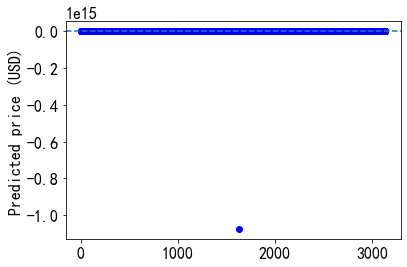

In [225]:
plt.plot(y_pred_L, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

Thinking about what I actually want from my model, I don't care so much if there are a few outliers for which price predictions are very poor. I'm more concerned with the *median* absolute fractional error, not the *mean* absolute error. I'll express this as a percent.

In [226]:
def median_abs_pct_err(y_true, y_pred):
    ''' INPUTS: y_true - a series or 1d array holding the true target values.
                y_pred - a series or 1d array holding the predicted target values.
        OUTPUTS: err - the median of the absolute value of the prediction error,
                 expressed as a percentage.
    '''
    err = 100*np.abs((y_true - y_pred)/y_true).median()
    return err

Now I can use this function to score the predictions:

In [227]:
median_abs_pct_err(y_train, y_pred_L)

38.92045484925327

Still quite awful: half of the predictions are off by over 450%.

Now I use the `make_scorer` function to make `median_abs_pct_err` suitable for input in an sklearn pipeline.

In [228]:
median_scorer = make_scorer(median_abs_pct_err)

I also write a function that returns the absolute relative error (in percent) for each prediction and returns the results as a dataframe.

In [230]:
def df_pct_abs_err(y_pred, y_true, plot=False, plot_cutoff=300):
    '''INPUTS: y_true - a series or 1d array holding the true target values.
               y_pred - a series or 1d array holding the predicted target values.
               plot - a boolean determining whether to plot the output `df` in
               a histogram.
               plot_cutoff - the upper cutoff on the histogram's x-axis. Only
               applicable if plot=True.
       OUTPUTS: df - a dataframe containing the absolute value of the prediction
                     error for each instance, expressed as a percentage.
                If plot=True, a histogram of df is shown.
    '''
    df = pd.DataFrame(100*np.abs((y_true - y_pred)/y_true))
    df = df.rename(columns={'price':'pct_abs_err'})
    if plot:
        df[df['pct_abs_err'] < plot_cutoff].hist()
        plt.ylabel("Number of occurrences")
        plt.xlabel("Absolute error in price prediction (%)")
        plt.title
        plt.show()
    return df

Now I can use this function to make a histogram of the absolute errors. I also check that the median matches what I got above:

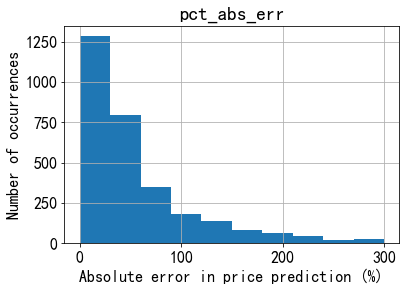

38.92045484925327

In [231]:
df_pct_abs_err(y_pred_L, y_train, plot=True).median().item()

Find score the predictions using different cutoffs using my median-based scorer, instead of $R^2$:

In [232]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 68.9, Standard error = 1.79, n_features = 3
Cutoff = 1, Mean score = 38.8, Standard error = 0.645, n_features = 36
Cutoff = 0.9, Mean score = 38.7, Standard error = 0.827, n_features = 48
Cutoff = 0.7, Mean score = 39.5, Standard error = 0.839, n_features = 58
Cutoff = 0.3, Mean score = 39.7, Standard error = 0.649, n_features = 78
Cutoff = 0.1, Mean score = 39.4, Standard error = 0.385, n_features = 99
Cutoff = 0.05, Mean score = 38.4, Standard error = 0.826, n_features = 112
Cutoff = 0.01, Mean score = 38.8, Standard error = 0.814, n_features = 152
Cutoff = 0.005, Mean score = 38.3, Standard error = 0.828, n_features = 179
Cutoff = 0.003, Mean score = 37.9, Standard error = 1.03, n_features = 185
Cutoff = 0.001, Mean score = 38.7, Standard error = 1.03, n_features = 226
Cutoff = 0, Mean score = 38.9, Standard error = 1.16, n_features = 315


These mean scores are the mean of the median absolute percentage error, computed across the five cross-validation folds.

### Dealing with outliers

If a listing has an absurdly high price that isn't reflective of what people will actually pay, or just isn't that relevant for a typical person who wants to list their place, that isn't good for the usefulness of our model. Models that are trained using $L^2$ loss, including `LinearRegression()`, penalize outliers (in the target variable) very sharply, which can be problematic for training (i.e. mimizing the mean-squared loss). Therefore, I'll take a look at places that have extremely high prices and see if it makes sense to remove them.

Plot the price for each listing:

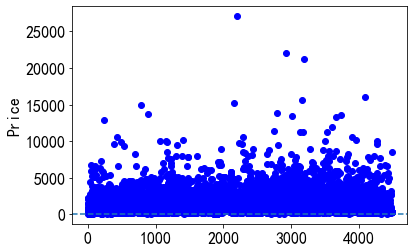

In [233]:
plt.plot(listings['price'], 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel("Price")
plt.show()

Yeah, some of these prices look like they might be absurd. Here are the highest ones:

In [234]:
listings['price'].sort_values(ascending=False).head(30)

2205    27080.0
2927    22000.0
3186    21286.0
4088    16000.0
3156    15600.0
2154    15214.0
781     15000.0
2785    13800.0
886     13714.0
3728    13626.0
3012    13510.0
3653    13260.0
244     12857.0
3592    12000.0
2747    11463.0
3530    11312.0
3169    11285.0
3128    11229.0
3898    10584.0
2293    10571.0
427     10571.0
1407    10214.0
3953    10167.0
1068    10000.0
1147    10000.0
4266    10000.0
3495     9999.0
484      9880.0
1172     9880.0
2228     9800.0
Name: price, dtype: float64

In [235]:
# Find the URL of one of the most expensive places
listings.loc[2648, 'listing_url']

'https://www.airbnb.com/rooms/45517465'

What is going on here? Following the link above, this is clearly a luxury place, but it's just a studio! On top of that, it's currently listed at USD 1,653 per night (as of December 3, 2021), not USD 48,864 per night as above. Let's take a closer look at `calendar` to see what happened:

Find the listing id of one of the most expensive listings:

In [236]:
listing_id = listings.loc[2648, 'id']

Find the adjusted price of this listing from the `calendar` dataframe:

In [237]:
calendar.loc[calendar['listing_id']==listing_id, ['date', 'price', 'adjusted_price']]

,date,price,adjusted_price
981839,2021-10-26,2355.0,2355.0
981840,2021-10-27,2355.0,2355.0
981841,2021-10-28,2355.0,2355.0
981842,2021-10-29,2355.0,2355.0
981843,2021-10-30,2355.0,2355.0
...,...,...,...
982199,2022-10-21,2355.0,2355.0
982200,2022-10-22,2355.0,2355.0
982201,2022-10-23,2355.0,2355.0
982202,2022-10-24,2355.0,2355.0


OK, it appears that the adjusted price was very high in mid-October, and that's what was pulled into the `price` field in `listings`. My understanding is that Airbnb allows hosts to turn on a setting that automatically adjusts the price according to demand (using some model developed by Airbnb), so likely demand was extremely high at nearby properties at that time. In any case, it would make sense for me to exclude this property and related ones from my data; I note that each of the properties over USD 10,000 are in the "Ginosi 747 Apartel", as can be easily verified by clicking on those URLs. Further, one of the next most expensive listings, at USD 9,999, is a 12-bedroom mansion.

Now I'll delete these outliers (those listings with prices above USD 10,000 per night). It makes sense to do this across all the data (not just for the training data), since I'm not interested in making predictions for places where the price would be that high (totally out of whack with what almost everyone would pay - prices that would actually banned by law for similar hotel accommodations), and I'd like to use all the data to create my final model.

Find the indices of listings with price greater than USD 10,000 per night:

In [238]:
to_drop = y[y > 10000].index

In [239]:
# Drop the necessary rows
X.drop(to_drop, inplace=True)
y.drop(to_drop, inplace=True)
# Drop the rows from the original dataframe as well (since I'll use this dataframe
# again shortly)
listings.drop(to_drop, inplace=True)

In [240]:
# Do the train-test splits again
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val_train, X_val, y_val_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

### Linear model, again

Fit the model to the new training set and evaluate using cross-validation and my median-based scorer:

In [244]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 66.8, Standard error = 1.51, n_features = 3
Cutoff = 1, Mean score = 39.9, Standard error = 0.598, n_features = 36
Cutoff = 0.9, Mean score = 39.8, Standard error = 0.576, n_features = 48
Cutoff = 0.7, Mean score = 38.9, Standard error = 0.429, n_features = 58
Cutoff = 0.3, Mean score = 37.3, Standard error = 0.812, n_features = 78
Cutoff = 0.1, Mean score = 38.4, Standard error = 0.908, n_features = 99
Cutoff = 0.05, Mean score = 37.9, Standard error = 1.16, n_features = 112
Cutoff = 0.01, Mean score = 37.2, Standard error = 0.688, n_features = 153
Cutoff = 0.005, Mean score = 37.6, Standard error = 0.36, n_features = 178
Cutoff = 0.003, Mean score = 37.9, Standard error = 0.738, n_features = 188
Cutoff = 0.001, Mean score = 38.7, Standard error = 0.761, n_features = 224
Cutoff = 0, Mean score = 38.1, Standard error = 0.894, n_features = 302


Get the predictions on the training set for the best model:

In [245]:
y_pred_L = fit_model(X_train, y_train, LinearRegression(), cutoff=0.001)

Plot the error for these predictions:

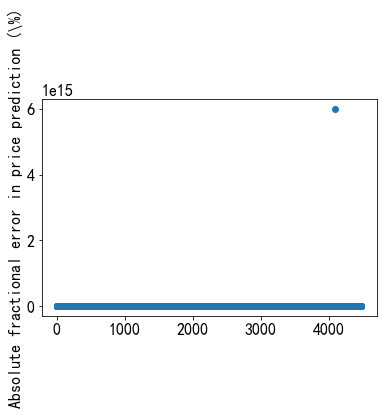

In [249]:
plt.plot(100*np.abs(y_train - y_pred_L)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

Plot the predicted prices to get an idea of how large they are:

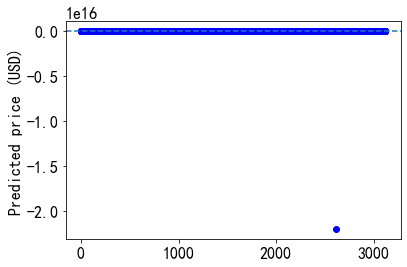

In [246]:
plt.plot(y_pred_L, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

Make a histogram of the relative absolute errors:

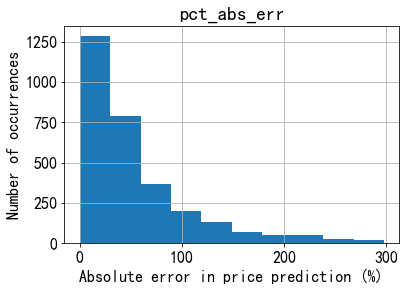

In [247]:
df_err_L = df_pct_abs_err(y_pred_L, y_train, plot=True)

Evaluate the median of these errors:

In [248]:
df_err_L['pct_abs_err'].median()

38.36648504586378

That is, 50% of predictions are off from the true price by less than 40%.

This is certainly better than the previous model, though still not great, and a fair number of the predictions are still negative.

### Smaller linear model and Visualizations

What happens if I just use a smaller model? Maybe the one above is too big and has a lot of unnecessary features, even using cutoffs as above. What do we expect to be the most useful factors for price prediction? My guesses for the most important: Its size (number of people, number of bedrooms and bathrooms), the property type (entire home, condo, etc.) and/or room type, and the neighborhood.

To start off, I'll do some visualizations to gain intuition about the importance of these features. I think violin plots are a good way to do this - they are an effective way to get a quick idea of the price distribution for different groups just by looking.

First, I'll take a look at the effect of the neighborhood on the price. I'll restrict to the 10 neighborhoods with the most listings so the x-axis isn't too crowded, and I'll cut the y-axis (price) off at USD 500 so that the distributions are easy to see. Note that cutting the *data* at a price of USD 500 would not be as informative, as it would skew the distributions of themselves (in particular, the medians - the points in the middle of the violins in the following plot).  Note also that above I removed the enormous outliers from `listings` (the ones that are priced above USD 10k per night), so they won't skew the distribution for West Town.

Determine the 10 neighborhooods with the most listings:

In [250]:
top_10_nbds = listings['neighbourhood_cleansed'].value_counts()[:10].index

Make a dataframe that contains only the listings in those neighborhoods:

In [251]:
df = listings.loc[listings['neighbourhood_cleansed'].isin(top_10_nbds)]

Make a violin plot of the prices for listings in these neighborhoods:

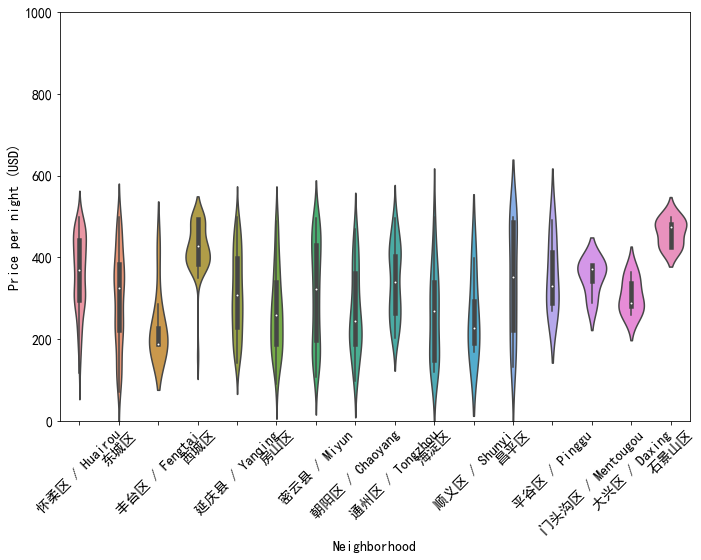

In [256]:
plt.figure(figsize=(10,8))
sns.violinplot(data=df, x='neighbourhood_cleansed', y='price')
plt.rcParams['font.size'] = 14
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Price per night (USD)')
plt.ylim(0, 1000)
plt.tight_layout()
plt.savefig('neighborhood_vs_price.jpg')
plt.show()

The price definitely has a reasonable degree of dependence on the neighborhood. Near South Side listings command particularly high prices on average, as do those in the Loop and to some extent in Lincoln Park and Near North side; and Lower West Side listings particularly low ones. It's also notable that listings in Near South Side and Lower West Side are clustered in relatively narrow ranges about their medians, whereas the other neighborhoods, especially Lake View and Loop, have much wider distributions.

Of course, a problem here is that I'm not controlling for other factors, such as the size of the property. For example, maybe properties on the Near South Side have more bedrooms on average, and properties on the Lower West Side have fewer; then a possibility is that the number of bedrooms strongly affects the price, and the neighborhood's effect is just incidental. Still, it's useful to see the correlation between neighborhood and price, at least for gaining some intuition and thinking of further questions to pose.

Note also that violin plots are useful, but not without their flaws- the price cannot be negative, but the kernel density estimators allow the probability distributions to be nonzero for negative price values for smoothness purposes.

Next I'll take a look at how the number of bedrooms affects the price.

Find the most common values for the number of bedrooms:

In [253]:
top_bedrooms = listings['bedrooms'].value_counts()[:6].index

Make a dataframe that has only the listings where the number of bedrooms is in these top six:

In [254]:
df = listings.loc[listings['bedrooms'].isin(top_bedrooms)]
df = df.loc[df['price'] < 500]

Make a violin plot of the price for each of these numbers of bedrooms:

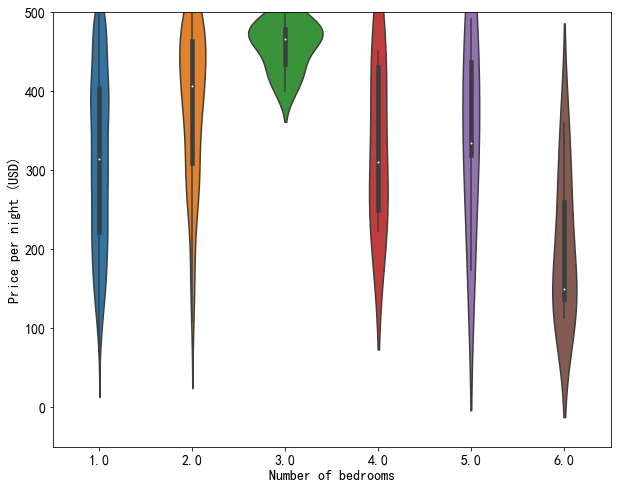

In [255]:
plt.figure(figsize=(10,8))
sns.violinplot(data=df, x='bedrooms', y='price')
plt.xlabel('Number of bedrooms')
plt.ylabel('Price per night (USD)')
plt.rcParams['font.size'] = 14
plt.savefig('bedrooms_vs_price.jpg')
plt.ylim(-50, 500)
plt.show()

Number of bedrooms is highly positively correlated with price, as expected.

How about the effect of the room type?

Find the possible room types:

In [87]:
room_types = listings['room_type'].value_counts().index

In [88]:
room_types

Index(['Entire home/apt', 'Private room', 'Shared room'], dtype='object')

There are only four of them, so I may as well show them all. I'll cut off the price at USD 300 for this plot.

In [89]:
df = listings.loc[listings['price'] < 300]

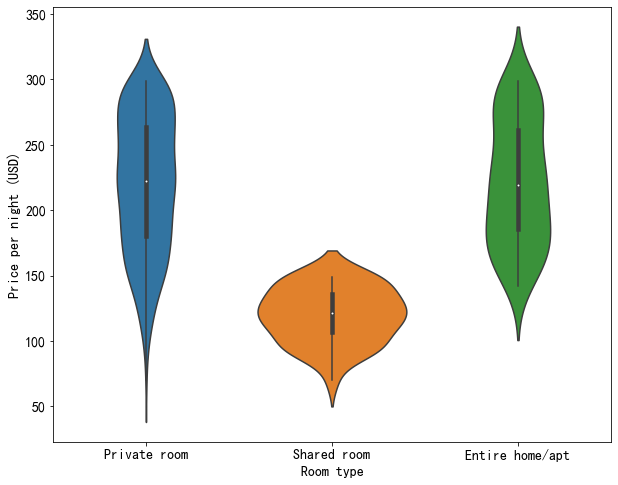

In [90]:
plt.figure(figsize=(10,8))
sns.violinplot(data=df, x='room_type', y='price')
plt.rcParams['font.size'] = 16
plt.xlabel('Room type')
plt.ylabel('Price per night (USD)')
plt.savefig('room_type_vs_price.jpg')
plt.show()

As one would expect, shared rooms tend to have lower prices, and entire homes/apartments tend to have higher ones.

I feel reasonably justified in my choice of features for this smaller training set. So let's go ahead with it and make a dataframe with just the appropriate columns from `listings`:

In [257]:
X_small = listings[['neighbourhood_cleansed','accommodates',
                    'bathrooms_text','bedrooms','beds',
                   'property_type', 'room_type']]

Get dummies for the categorical variables:

In [258]:
X_small = pd.get_dummies(X_small, drop_first=True)

Make a copy of the series holding the prices:

In [93]:
y_small = y.copy()

I need to deal with the `NaN` entries in `beds` and `bedrooms`. For row `x`, if `x['beds']` is `NaN` then I'll make its value `x['bedrooms']`, and vice-versa.

In [94]:
X_small['bedrooms'] = X_small.apply(lambda x: x['beds'] if not(x['bedrooms']>0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['bedrooms'] if not(x['beds']>0) else x['beds'], axis=1)

In [95]:
sum(X_small.isna()['beds'])

0

In [96]:
X_small.loc[X_small.isna()['bedrooms']]

,accommodates,bedrooms,beds,neighbourhood_cleansed_丰台区 / Fengtai,neighbourhood_cleansed_大兴区 / Daxing,neighbourhood_cleansed_密云县 / Miyun,neighbourhood_cleansed_平谷区 / Pinggu,neighbourhood_cleansed_延庆县 / Yanqing,neighbourhood_cleansed_怀柔区 / Huairou,neighbourhood_cleansed_房山区,...,property_type_Shared room in cottage,property_type_Shared room in farm stay,property_type_Shared room in hostel,property_type_Shared room in kezhan,property_type_Shared room in rental unit,property_type_Shared room in villa,property_type_Tiny house,property_type_Treehouse,room_type_Private room,room_type_Shared room


There are still some `NaN` values in these columns, and they always occur together now. So in this case, I'll set `x['beds']` and `x['bedrooms']` equal to `x['accommodates']/2`.

In [97]:
X_small['bedrooms'] = X_small.apply(lambda x: x['accommodates']/2 if not(x['bedrooms'] > 0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['accommodates']/2 if not(x['beds'] > 0) else x['beds'], axis=1)

If a listing accommodates 0 people, I'll drop it.

In [98]:
to_drop = X_small.loc[X_small['accommodates'] == 0].index
X_small.drop(to_drop, inplace=True)
y_small.drop(to_drop, inplace=True)

Now do the train-test split:

In [99]:
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42)

Fit the model to the training set and evaluate using cross-validation and my median-based scorer:

In [259]:
cutoffs = [1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0.0005, 0]
test_cutoffs(X_small_train, y_small_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1, Mean score = 39.8, Standard error = 0.621, n_features = 3
Cutoff = 0.9, Mean score = 39.8, Standard error = 0.621, n_features = 3
Cutoff = 0.7, Mean score = 39.8, Standard error = 0.621, n_features = 3
Cutoff = 0.3, Mean score = 39.9, Standard error = 0.285, n_features = 4
Cutoff = 0.1, Mean score = 38.9, Standard error = 0.963, n_features = 12
Cutoff = 0.05, Mean score = 38, Standard error = 1.18, n_features = 22
Cutoff = 0.01, Mean score = 37.3, Standard error = 1.05, n_features = 49
Cutoff = 0.005, Mean score = 36.7, Standard error = 1.11, n_features = 68
Cutoff = 0.003, Mean score = 36.8, Standard error = 1.01, n_features = 73
Cutoff = 0.001, Mean score = 36.6, Standard error = 1.09, n_features = 92
Cutoff = 0.0005, Mean score = 36.7, Standard error = 1.15, n_features = 115
Cutoff = 0, Mean score = 36.4, Standard error = 1.07, n_features = 138


Not bad! It looks like I guessed some of the most important factors correctly, getting a better score than my best linear model that includes all the features.

Get the predictions on the training set (using cross-validation):

In [260]:
y_pred_small = fit_model(X_small_train, y_small_train, LinearRegression(), cutoff=0)

Plot the absolute relative error for each prediction in a histogram, cut off at 300%, and show the median:

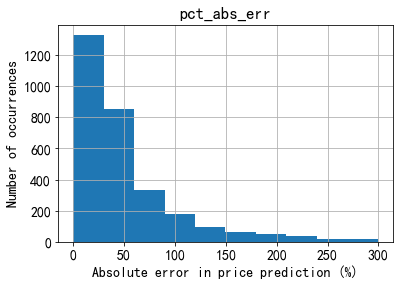

36.25346178037752

In [261]:
df_pct_abs_err(y_pred_small, y_small_train, plot=True).median().item()

### Elastic net

There are more sophisticated models that help me get rid of irrelevent features by setting their weights to zero in the model. I'll use sklearn's `ElasticNet`, which has this favorable Lasso property while also having the L2 regularization properties of ridge regression.

Import the model from sklearn:

In [262]:
from sklearn.linear_model import ElasticNet

Train it on the training data with various cutoffs, and score its predictions (on the training set via cross-validation) using my median-based scorer:

In [263]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, ElasticNet(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 66.8, Standard error = 1.51, n_features = 3
Cutoff = 1, Mean score = 42.4, Standard error = 0.639, n_features = 36
Cutoff = 0.99, Mean score = 42.1, Standard error = 0.714, n_features = 41
Cutoff = 0.5, Mean score = 40.6, Standard error = 0.787, n_features = 66
Cutoff = 0.3, Mean score = 39.8, Standard error = 0.822, n_features = 78
Cutoff = 0.2, Mean score = 39.9, Standard error = 0.751, n_features = 88
Cutoff = 0.1, Mean score = 38.1, Standard error = 0.822, n_features = 99
Cutoff = 0.05, Mean score = 37.8, Standard error = 0.878, n_features = 112
Cutoff = 0.01, Mean score = 36.2, Standard error = 0.684, n_features = 153
Cutoff = 0.005, Mean score = 35.3, Standard error = 0.58, n_features = 178
Cutoff = 0.002, Mean score = 34.8, Standard error = 0.585, n_features = 197
Cutoff = 0.001, Mean score = 34.8, Standard error = 0.572, n_features = 224
Cutoff = 0.0005, Mean score = 34.4, Standard error = 0.591, n_features = 267
Cutoff = 0, Mean score = 34.6, Stand

Not significantly better than my smaller linear model above.

Get the predictions for the best model:

In [264]:
y_pred_E = fit_model(X_train, y_train, ElasticNet(), cutoff=0)

Plot the median-based score:

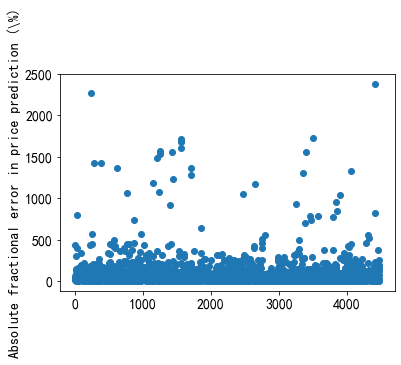

In [265]:
plt.plot(100*np.abs(y_train - y_pred_E)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

Plot the predictions (note in particular that more of them are positive):

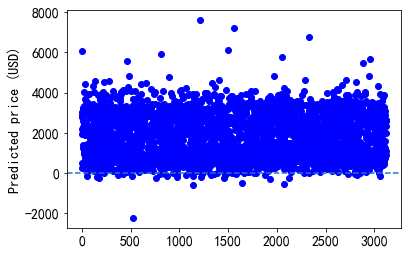

In [266]:
plt.plot(y_pred_E, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

Plot the absolute relative errors in a histogram:

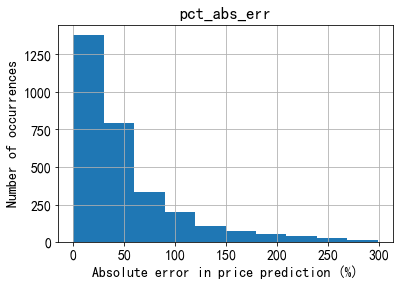

In [267]:
df_err_E = df_pct_abs_err(y_pred_E, y_train, plot=True)

Check that the median absolute relative error % is the same:

In [268]:
df_err_E.median().item()

34.458804506718295

The CV score (mean $R^2$ between folds) and the median absolute error have both improved, though not substantially.

What are the most important features? For these results to be robust, I average the coefficients over the five folds obtained during cross-validation.

Make the pipeline:

In [269]:
pipe = make_pipeline(StandardScaler(), ElasticNet())

Get the predictions on the training set using cross-validation, and find the average model coefficients across the five predictors:

In [270]:
cv_dict = cross_validate(pipe, X_train, y_train, return_estimator=True)
estimators = cv_dict['estimator']
coeffs = np.zeros(X_train.shape[1])
for i in range(5):
    coeffs += estimators[i].named_steps['elasticnet'].coef_
coeffs /= 5

Show the most important coefficients:

In [271]:
df = pd.DataFrame(np.array([X_train.columns, coeffs, np.abs(coeffs)]).T, columns=['feature','coeff', 'abs_coeff'])
df = df.sort_values(by='abs_coeff', ascending=False)
df.head(30)

,feature,coeff,abs_coeff
7,accommodates,244.504586,244.504586
8,bedrooms,237.723976,237.723976
263,bathrooms_text_1 bath,-125.183354,125.183354
9,beds,118.00614,118.00614
264,bathrooms_text_1 private bath,-114.595271,114.595271
209,property_type_Entire villa,102.319639,102.319639
76,First aid kit,98.445312,98.445312
311,bathrooms_text_6 baths,97.947852,97.947852
316,bathrooms_text_7.5 baths,91.128448,91.128448
303,bathrooms_text_4 baths,79.025815,79.025815


| Feature             | Impact on price |
|---------------------|-----------------|
| 6 bathrooms         | \$28.40          |
| Number of bedrooms  | $22.88          |

Interestingly, the top 20 features or so all have positive coefficients, except for one (the "only one bathroom" feature). The larger the values of those features are, the larger we expect the price to be.

As was hinted at by smaller linear model above, the most important features are related to the number of bedrooms, number of bathrooms (in particular, having more than one), offering the entire home, and being in a desirable neighborhood for travelers. `availability_30`, the number of days in the next 30 days for which a property is available, also has an impact on raising the price.

Make a dataframe that has all the instances in $X$ but only keeps the top 20 features:

In [272]:
X_top_20 = X[df[:20]['feature']].copy()

Do the train-test split:

In [273]:
X_top_20_train, X_top_20_test, y_top_20_train, y_top_20_test = train_test_split(
    X_top_20, y, test_size=0.3, random_state=42)

Note also that ElasticNet eliminates some features by setting their coefficients to zero.

In [274]:
len(df.loc[df['abs_coeff']==0])

35

To be exact, it does this for 156 features. I will also make a dataframe that has all the instances of $X$ but excludes these features only:

In [275]:
X_E = X.drop(list(df.loc[df['abs_coeff']==0, 'feature']), axis=1)

Do the train-test split again:

In [276]:
X_E_train, X_E_test, y_E_train, y_E_test = train_test_split(
    X_E, y, test_size=0.3, random_state=42)

I'd like to build some more accurate models, even if they are less interpretable. In particular, I'll try k-nearest neighbors and random forest models, as they are relatively fast to train and don't have many hyperparameters to tune.

### k-Nearest neighbors

Import the regressor from sklearn:

In [277]:
from sklearn.neighbors import KNeighborsRegressor

I think using the $L^1$ metric for the k-NN tree will work better than using the $L^2$ metric (standard Euclidean distance), since the $L^1$ metric is less sensitive to outliers.

Next, I fit the model to the training set with various cutoffs and then score it using my median-based scorer. Note that the weight function used in prediction weights the points by the inverse of their distance, since I'm using `weights='distance'` instead of `weights='uniform'`. I'm also using `p=1`(Manhattan distance, $L^1$), instead of `p=2` (Euclidean distance, $L^2$), since the Manhattan distance is less sensitive to outliers.

In [278]:
# Showing median absolute fractional error (%) scores
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, KNeighborsRegressor(weights='distance', p=1), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 74, Standard error = 1.94, n_features = 3
Cutoff = 1, Mean score = 31.3, Standard error = 0.92, n_features = 36
Cutoff = 0.99, Mean score = 31.3, Standard error = 0.906, n_features = 41
Cutoff = 0.5, Mean score = 31.6, Standard error = 1.08, n_features = 66
Cutoff = 0.3, Mean score = 32.1, Standard error = 1.05, n_features = 78
Cutoff = 0.2, Mean score = 32.3, Standard error = 1.08, n_features = 88
Cutoff = 0.1, Mean score = 31.9, Standard error = 1.28, n_features = 99
Cutoff = 0.05, Mean score = 30.8, Standard error = 1.2, n_features = 112
Cutoff = 0.01, Mean score = 29.7, Standard error = 0.567, n_features = 153
Cutoff = 0.005, Mean score = 29.6, Standard error = 0.486, n_features = 178
Cutoff = 0.002, Mean score = 29.1, Standard error = 0.452, n_features = 197
Cutoff = 0.001, Mean score = 28.6, Standard error = 0.262, n_features = 224
Cutoff = 0.0005, Mean score = 29.2, Standard error = 0.413, n_features = 267
Cutoff = 0, Mean score = 29.1, Standard erro

What is the minimal mean score if I use the $L^2$ metric (Euclidean distance) instead?

In [279]:
min(test_cutoffs(X_train, y_train, KNeighborsRegressor(weights='distance'),
             cutoffs, scoring=median_scorer, print_results=False))

29.177295745074083

It's a bit worse, as expected.

I can also vary the number of neighbors to see if this yields any improvement. The default value for `n_neighbors` is 5.

In [280]:
for n in [3, 5, 10, 20]:
    scores = score_model(X_train, y_train,
                         KNeighborsRegressor(n_neighbors=n, weights='distance', p=1), 
                         0.05, scoring=median_scorer)
    print(f"n_neighbors = {n} gives mean score {scores.mean():.3g} with standard error {scores.std()/np.sqrt(5):.3g}")

n_neighbors = 3 gives mean score 29 with standard error 1
n_neighbors = 5 gives mean score 30.8 with standard error 1.2
n_neighbors = 10 gives mean score 32.4 with standard error 1.03
n_neighbors = 20 gives mean score 34.9 with standard error 0.505


Using `n_neighbors` of 3 instead of 5 gives slightly better mean score, although they're within each others' standard errors.

The $R^2$ scores are worse than for the previous model, but the median absolute error is better. K-nearest neighbors does not use the $L^2$ loss as the previous methods do; it instead looks at the prices for the nearest neighbors (in this case, 5 such neighbors) of a listing to estimate that listing's price. Thus, it is not as sensitive to outliers.

Get the predictions (on the training set via cross-validation) for the best model:

In [281]:
y_pred_knn = fit_model(X_train, y_train, KNeighborsRegressor(weights='distance', p=1),
                       cutoff=0.05)

Show the individual absolute fractional errors (%), cut off at 300%, in a histogram:

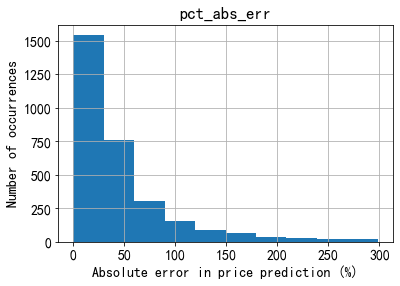

In [282]:
df_err_knn = df_pct_abs_err(y_pred_knn, y_train, plot=True)

Verify that the median matches what I got above:

In [283]:
df_err_knn['pct_abs_err'].median()

30.381374884012118

Show all the absolute fractional errors (in percent), without cutting off at 300%:

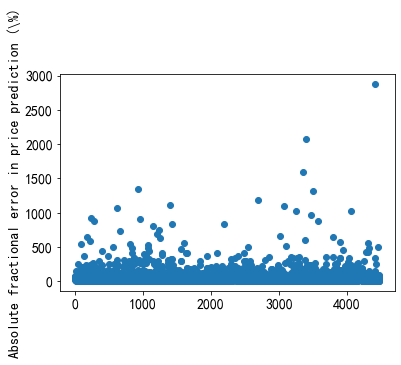

In [284]:
plt.plot(100*np.abs(y_train - y_pred_knn)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

Show the price predictions:

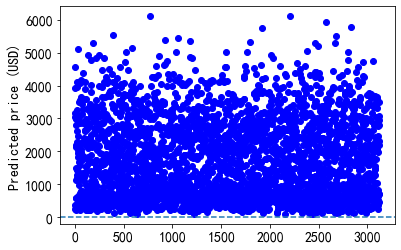

In [285]:
plt.plot(y_pred_knn, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

Find the number of predictions that are less than zero:

In [286]:
sum(y_pred_knn < 0)

0

None of the predictions are less than zero - a big advantage over the linear models.

What if I use the information I gained from the Elastic Net regression? That is, I will use the data with irrelevant features removed.

Train the model on the training set that was reduced by removing the features with zero coefficients in the above Elastic Net model, using various cutoffs and scoring using my median-based scorer:

In [287]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_E_train, y_train, KNeighborsRegressor(weights='distance', p=1),
             cutoffs, scoring=median_scorer);

/Users/momo/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/momo/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/momo/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/momo/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_tra

Cutoff = 1e+03, Mean score = nan, Standard error = nan, n_features = 0
Cutoff = 1, Mean score = 31.3, Standard error = 0.92, n_features = 33
Cutoff = 0.99, Mean score = 31.3, Standard error = 0.906, n_features = 35
Cutoff = 0.5, Mean score = 31.6, Standard error = 1.08, n_features = 60
Cutoff = 0.3, Mean score = 32.1, Standard error = 1.05, n_features = 72
Cutoff = 0.2, Mean score = 32.3, Standard error = 1.08, n_features = 82
Cutoff = 0.1, Mean score = 31.9, Standard error = 1.28, n_features = 93
Cutoff = 0.05, Mean score = 30.8, Standard error = 1.2, n_features = 106
Cutoff = 0.01, Mean score = 29.7, Standard error = 0.567, n_features = 147
Cutoff = 0.005, Mean score = 29.6, Standard error = 0.486, n_features = 172
Cutoff = 0.002, Mean score = 29.1, Standard error = 0.452, n_features = 191
Cutoff = 0.001, Mean score = 28.6, Standard error = 0.262, n_features = 218
Cutoff = 0.0005, Mean score = 29.2, Standard error = 0.413, n_features = 261
Cutoff = 0, Mean score = 29.1, Standard erro

The scores are the same (within the standard errors of each other).

What if we use just the most important features, as determined from the `ElasticNet()` coefficients?

In [288]:
cutoffs = [1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_top_20_train, y_train, KNeighborsRegressor(weights='distance', p=1),
             cutoffs, scoring=median_scorer);

Cutoff = 1, Mean score = 39.5, Standard error = 0.992, n_features = 3
Cutoff = 0.99, Mean score = 39.5, Standard error = 0.992, n_features = 3
Cutoff = 0.5, Mean score = 37.2, Standard error = 0.876, n_features = 5
Cutoff = 0.3, Mean score = 37.2, Standard error = 0.876, n_features = 5
Cutoff = 0.2, Mean score = 36.3, Standard error = 0.803, n_features = 7
Cutoff = 0.1, Mean score = 35.3, Standard error = 0.699, n_features = 10
Cutoff = 0.05, Mean score = 34.4, Standard error = 0.708, n_features = 14
Cutoff = 0.01, Mean score = 34.4, Standard error = 0.764, n_features = 15
Cutoff = 0.005, Mean score = 34.6, Standard error = 0.51, n_features = 16
Cutoff = 0.002, Mean score = 34.5, Standard error = 0.55, n_features = 17
Cutoff = 0.001, Mean score = 34.6, Standard error = 0.539, n_features = 18
Cutoff = 0.0005, Mean score = 34.8, Standard error = 0.563, n_features = 19
Cutoff = 0, Mean score = 34.9, Standard error = 0.594, n_features = 20


This is actually worse. It seems that k-nearest neighbors uses the additional information from other features to good effect.

### Random forest

Import the regressor from sklearn:

In [289]:
from sklearn.ensemble import RandomForestRegressor

I will choose to use absolute error, instead of mean-squared error, as the criterion to minimize, since it is less sensitive to outliers.

Train the model using various cutoffs:

In [290]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, RandomForestRegressor(n_estimators=10,
                                                     criterion='absolute_error',
                                                    random_state=42),
             cutoffs, scoring=median_scorer);

        

Cutoff = 1e+03, Mean score = 63.7, Standard error = 0.585, n_features = 3
Cutoff = 1, Mean score = 30, Standard error = 0.689, n_features = 36
Cutoff = 0.99, Mean score = 29.4, Standard error = 0.324, n_features = 41
Cutoff = 0.5, Mean score = 28.8, Standard error = 1.08, n_features = 66
Cutoff = 0.3, Mean score = 29.4, Standard error = 1.27, n_features = 78
Cutoff = 0.2, Mean score = 28.2, Standard error = 1.32, n_features = 88
Cutoff = 0.1, Mean score = 28.4, Standard error = 1.38, n_features = 99
Cutoff = 0.05, Mean score = 27.8, Standard error = 0.855, n_features = 112
Cutoff = 0.01, Mean score = 27.5, Standard error = 1.01, n_features = 153
Cutoff = 0.005, Mean score = 27.4, Standard error = 0.792, n_features = 178
Cutoff = 0.002, Mean score = 28, Standard error = 1.03, n_features = 197
Cutoff = 0.001, Mean score = 27.3, Standard error = 1.27, n_features = 224
Cutoff = 0.0005, Mean score = 27.3, Standard error = 1.07, n_features = 267
Cutoff = 0, Mean score = 27.2, Standard error 

This is significantly more computationally expensive to train than k-nearest neighbors (it took about a hundred times as long on my laptop), but it performs no better.

Get the predictions on the training set for the best of these models:

In [291]:
y_pred_rf = fit_model(X_train, y_train, RandomForestRegressor(
    n_estimators=10, criterion='absolute_error', random_state=42), cutoff=0)

Show the individual errors in a histogram, cut off at 300%:

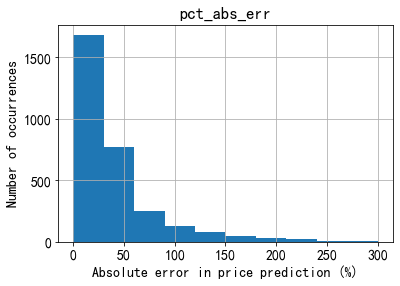

In [292]:
df_err_rf = df_pct_abs_err(y_pred_rf, y_train, plot=True)

Show all the errors (with no upper cutoff):

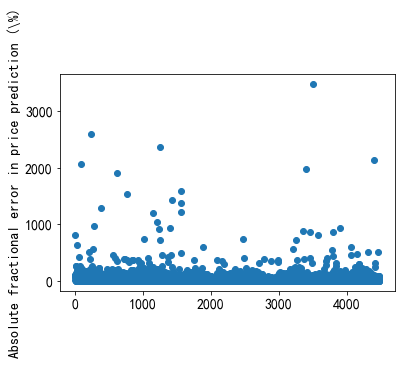

In [293]:
plt.plot(100*np.abs(y_train - y_pred_rf)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

## Final evaluation

It's time to stop holding back the test set.

In [294]:
def do_final_fit(X_train, y_train, X_test, y_test, model, cutoff):
    ''' This is similar to the do_fit() function in the 'Linear model' section,
        but it returns the pipe in addition to the score, and evaluates on the
        test set instead of using cross-validation.
        INPUTS: X_train - a dataframe with the training data.
                y_train - a series with the training targets.
                X_test - a dataframe with the test data.
                y_test - a series with the test set targets.
                model - the model to fit and use for predictions.
                cutoff - a parameter determining the number of features to keep.
                         Features with mean value across training instances of
                         less than this cutoff are discarded.
        OUTPUTS: pipe - an sklearn pipe that can be used to make predictions
                        given an input in the form of a dataframe X of instances.
                 score - the score for the pipe's predictions on the test set
                         y_test. The score used here is the median absolute percent
                         error.
    '''
    pipe = make_pipeline(StandardScaler(), model)
    to_keep = np.where(np.abs(X_train.sum()/len(X_train)) > cutoff)[0]
    X_train_cutoff = X_train.iloc[:, to_keep]
    X_test_cutoff = X_test.iloc[:, to_keep]
    pipe.fit(X_train_cutoff, y_train)
    y_pred = pipe.predict(X_test_cutoff)
    score = median_abs_pct_err(y_test, y_pred)
    return pipe, score

Now I fit the best model from each category to the training set (using the cutoff that gave the best performance) and find the score for the predictions on the test set.

In [295]:
pipe_LM, score_LM = do_final_fit(X_train, y_train, X_test, y_test, 
                                 LinearRegression(), 0.001)
print(f"Median absolute fractional error, using best linear model of my initial kind = {score_LM:.3g}%")

Median absolute fractional error, using best linear model of my initial kind = 36.7%


In [296]:
pipe_SLM, score_SLM = do_final_fit(X_small_train, y_small_train, X_small_test, y_small_test, 
                                 LinearRegression(), 0)
print(f"Median absolute fractional error, using best \"smaller linear model\" = {score_SLM:.3g}%")

Median absolute fractional error, using best "smaller linear model" = 36.3%


In [297]:
pipe_EN, score_EN = do_final_fit(X_train, y_train, X_test, y_test, 
                                 ElasticNet(), 0)
print(f"Median absolute fractional error, using best Elastic Net = {score_EN:.3g}%")

Median absolute fractional error, using best Elastic Net = 35.6%


In [298]:
pipe_KNN, score_KNN = do_final_fit(X_train, y_train, X_test, y_test, 
                                 KNeighborsRegressor(n_neighbors=3,
                                                     weights='distance', p=1), 0.05)
print(f"Median absolute fractional error, using best k-nearest neighbors model = {score_KNN:.3g}%")

Median absolute fractional error, using best k-nearest neighbors model = 27.3%


In [299]:
pipe_RF, score_RF = do_final_fit(X_train, y_train, X_test, y_test, 
                                 RandomForestRegressor(n_estimators=10,
                                                       criterion='absolute_error',
                                                       random_state=42), 0)
print(f"Median absolute fractional error, using best random forest model = {score_RF:.3g}%")

Median absolute fractional error, using best random forest model = 26.3%


My best model, as judged by the median fractional error, is a k-nearest neighbors model with
3 neighbors, points weighted by the inverse of their distance, and using the taxicab metric as opposed to the Euclidean metric. I think it's a reasonable attempt at a pricing model for a short project; for 50% of listings in the test set, it's off from the true listed price by less than 22%.

## Deployment

To deploy the model, I first train it on the full set of data (train and test):

In [300]:
cutoff = 0.05
X_cutoff = X.iloc[:, np.where(np.abs(X.sum()/len(X)) > cutoff)[0]]
cols_after_cutoff = X_cutoff.columns
pipe_deployed = make_pipeline(StandardScaler(), 
                     KNeighborsRegressor(weights='distance', p=1))
pipe_deployed.fit(X_cutoff, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(p=1, weights='distance'))])

To make predictions on new data, I need to prepare the data as I prepared $X$. It will be useful to have a pipeline to do this. The following function, `data_prep_pipeline`, takes a csv file with listings I want to price and generates the fully cleaned $X$ matrix with all features.

In [307]:
def data_prep_pipeline(csv_file):
    ''' Takes a CSV file with listings in the proper format, and
        creates the dataframe X of inputs to a model, with the proper
        cleaning and preparation steps completed.
        INPUTS: csv_file - the name of the CSV file containing the listings;
                this file should be in the same directory as this Jupyter notebook.
        OUTPUTS: X - the dataframe that serves as input to the price model.
                 Its rows represent listings from the CSV file, and its columns
                 represent features from these listings.
    '''
    
    listings = pd.read_csv(csv_file)
    # Drop columns that were all NA in X
    listings.drop(columns=listings_na_cols, inplace=True)
    # Deal with percent signs in some columns
    listings['host_response_rate'] = listings.apply(lambda x: 
                                                    float(x['host_response_rate'].
                                                          replace('%','')) if 
                                                    pd.notnull(x['host_response_rate'])
                                                    else x['host_response_rate'], axis=1)
    listings['host_acceptance_rate'] = listings.apply(lambda x: 
                                                      float(x['host_acceptance_rate'].
                                                            replace('%','')) if 
                                                      pd.notnull(x['host_acceptance_rate']) 
                                                      else x['host_acceptance_rate'],
                                                      axis=1)

    # Create X by removing the 'price' field
    X = listings.drop('price', axis=1)

    # Convert timestamps to lengths of time
    for col in ['host_since', 'first_review', 'last_review']:
        X[col] = pd.to_datetime(X['last_scraped']) - pd.to_datetime(X[col])
        X[col] = X.apply(lambda x: x[col].days, axis=1)

    # Drop irrelevent features
    to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']
    to_drop += ['description', 'neighborhood_overview', 'picture_url', 'host_id']
    to_drop += ['host_url', 'host_name', 'host_about', 'host_thumbnail_url']
    to_drop += ['host_picture_url', 'license', 'calendar_last_scraped']
    X.drop(labels=to_drop, axis=1, inplace=True)

    # Make the 'host_verifications' and 'amenities' columns into lists
    # instead of strings
    X['host_verifications'] = X.apply(lambda x: x['host_verifications'].replace('[','').
                                      replace(']','').replace('\'','').split(', '), axis=1)
    X['amenities'] = X.apply(lambda x: x['amenities'].replace('\"','').replace('[','').
                             replace(']','').split(', '), axis=1)
    
    # I found the distinct `host_verifications` options in the Data Preparation
    # section. Now I can use a `MultiLabelBinarizer` to make a dummy column
    # for each option in `host_verifications`
    mlb_hv = MultiLabelBinarizer()
    mlb_hv.fit([distinct_host_verifications])
    hv_df = pd.DataFrame(mlb_hv.transform(X['host_verifications']), 
                      columns=mlb_hv.classes_, index=X.index)
    X = pd.concat([X, hv_df], axis=1)
    X.rename(columns={'None' : 'HV_None'}, inplace=True)
    X.drop('host_verifications', axis=1, inplace=True)
    
    # I found the top 20 amenities in my Data Preparation section above,
    # and defined `find_amenities(x)` to take a row x and keep only the 
    # amenities that are in the top 20
    X['amenities'] = X.apply(lambda x: find_amenities(x), axis=1)
    
    # In the same way as `host_verifications`, now split the different
    # amenities into their own dummy variables
    mlb_amenities = MultiLabelBinarizer()
    mlb_amenities.fit([top_20_amenities])
    amenities_df = pd.DataFrame(mlb_amenities.transform(X['amenities']),
                                columns=mlb_amenities.classes_, index=X.index)
    X = pd.concat([X, amenities_df], axis=1)
    X.drop('amenities', axis=1, inplace=True)
    
    # Now get dummy variables for the rest of the categorical features
    # I created `one_hot` in the Data Preparation section
    X_cat = X[cat_columns].copy()
    X_cat.fillna(value="NA", inplace=True)
    X_onehot = pd.DataFrame(one_hot.transform(X_cat),
                            columns=one_hot.get_feature_names_out(),
                           index = X.index)
    X.drop(columns=cat_columns, inplace=True)
    X = pd.concat([X, X_onehot], axis=1)
    
    # For numerical features that are NA, impute using the column means from X
    X.fillna(value=X_col_means, inplace=True)
    
    return X

Finally, I use the fitted model from above, `pipe_deployed`, and the appropriate columns of X, `cols_after_cutoff`, for that fitted model to make the price prediction.

In [313]:
def predict_price(X, pipe_deployed, cols_after_cutoff):
    ''' INPUTS: X - dataframe of inputs to the model.
                pipe_deployed - a pipeline with the final deployed model.
                cols_after_cutoff - the columns of X that are kept after a cutoff
                is used to remove features that have low mean values across all instances.
    '''
    X_cutoff = X[cols_after_cutoff]
    price = pipe_deployed.predict(X_cutoff)[0]
    return price

Now let's say I bought a property in Chicago that I want to list on Airbnb. What should I price it to be in line with typical prices for such a property?

My hypothetical property is a rental unit with two bedrooms and two bathrooms. It can accommodate four people (one bed per room), is in Hyde Park, and has reasonable amenities. I might guess I should price it around USD 200 per night.

Use the prep pipeline to put the data from the CSV file in a dataframe in the proper format, and appropriately clean it:

In [314]:
X_my = data_prep_pipeline('my_listing.csv')

ValueError: Found unknown categories ['Chicago, Illinois, United States'] in column 0 during transform

Get the price prediction:

In [312]:
predict_price(X_my, pipe_deployed, cols_after_cutoff)

NameError: name 'X_my' is not defined

So according to my best model, to be in line with typical pricing strategy, I should price my apartment at about USD 245 per night, just a little higher than what I expected.

Finding the **best** price for a given night, i.e. the one that maximizes the expected return (the price times the probability that it is booked that night) is a different problem. It seems to me that a significantly more sophisticated model would need to be developed to do this in a reasonable way throughout the year - perhaps a good future project. More data may also be needed to build a very good model of this type. In particular, data on whether a property was booked *in the past* (not whether it's available in the future) would be helpful for modeling the probability that a property with a given set of features would get rented at a given price on some night.

# Question 2: Variation in prices with time, by neighborhood

## Data preparation

I need to match the price for each listing, which is the `adjusted_price` column in the `calendar` dataframe, with the neighborhood in which that listing is located, which is the `neighbourhood_cleansed` in the `listings` dataframe. I need to do an inner join of these columns by the `id` value in `listings` with the `listing_id` value in `calendar`.

Select the appropriate columns of `calendar` and `listings`:

In [315]:
prices = calendar[['listing_id', 'adjusted_price', 'date']].copy()
neighborhoods = listings[['id', 'neighbourhood_cleansed']].copy()

Convert the date to a day (number of days after 2021-10-18):

In [317]:
# prices['day'] = pd.to_datetime(prices['date']) - pd.to_datetime('2021-10-18')
prices['day'] = pd.to_datetime(prices['date']) - pd.to_datetime('2021-10-26')
prices['day'] = prices.apply(lambda x: x['day'].days, axis=1)

Drop the original `date` column:

In [318]:
prices.drop('date', axis=1, inplace=True)

I'll make a function to convert the day (a nonnegative integer) to the date on or after 2021-10-18, for later convenience.

Make a dictionary that makes numbers from 0 to 6 correspond with days of the week (according to the pandas timestamp `dayofweek` attribute's convention):

In [319]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wendesday', 3:'Thursday'}
weekdays[4] = 'Friday'
weekdays[5] = 'Saturday'
weekdays[6] = 'Sunday'

Write the function to convert the day (from 0 to 364) to a date.

In [320]:
def day_to_date(day):
    '''INPUTS: day - an integer from 0 to 364 representing a day of the year starting
               on October 18, 2021 and ending on October 17, 2022.
       OUTPUTS: date - a string that gives the day of the week and the date
                corresponding to `day`.
    '''
    ts = pd.to_datetime('2021-10-18') + pd.to_timedelta(day, unit='d')
    day_of_week = weekdays[ts.dayofweek]
    date = str(ts).split()[0]
    date = day_of_week + ', ' + date
    return date

Rename some of the dataframe columns to be shorter and more idiomatic:

In [321]:
prices.rename({'listing_id': 'id', 'adjusted_price': 'price'},
              axis=1, inplace=True)
neighborhoods.rename({'neighbourhood_cleansed': 'neighborhood'},
                     axis=1, inplace=True)

(Inner) join the dataframes with neighborhood and price information by the `id` of each row:

In [322]:
price_by_nbd = pd.merge(neighborhoods, prices, on='id')

In [323]:
price_by_nbd.head()

,id,neighborhood,price,day
0,2797791,怀柔区 / Huairou,1200.0,0
1,2797791,怀柔区 / Huairou,1200.0,1
2,2797791,怀柔区 / Huairou,1200.0,2
3,2797791,怀柔区 / Huairou,1800.0,3
4,2797791,怀柔区 / Huairou,1800.0,4


## Evaluation (analysis and visualization)

I'm interested in figuring out how much the price varies over the course of the year for each listing. I'll quantify the variation *for a given property* by finding the standard deviation in its price over the course of the year and dividing by its mean price over the year. This is more informative than just using the standard deviation; I'd expect properties with higher mean price to have higher standard deviation in price (i.e. standard deviation scales with mean) - and what I'm after is the relative size of the fluctuation, not its absolute size. I can then get an idea of the distribution of this statistic in different neighborhoods using a violin plot.

Create a dataframe that shows the standard deviation of the price over the course of the year for each listing, scaled by that listing's mean price:

In [324]:
df_std = price_by_nbd.groupby(by='id').std()/price_by_nbd.groupby(by='id').mean()
df_std.rename({'price': 'fractional_std_of_price'}, axis=1, inplace=True)

In [325]:
df_std[['fractional_std_of_price']].head()

,fractional_std_of_price
id,
2797791,0.197818
4990531,0.000000
6801565,0.056844
6862828,0.048939
6956755,0.240097


Some hosts have not taken the time to set different prices for different times in the year ahead (and so the standard deviation is zero); these listings give me no information about the problem I'm trying to solve, so I'll drop them.

In [326]:
sum(df_std['fractional_std_of_price'] == 0)

587

There are 1515 such properties. Now, to drop them, find their indices:

In [327]:
ids_to_drop = df_std.loc[df_std['fractional_std_of_price'] == 0].index

And drop them:

In [328]:
df_std.drop(ids_to_drop, inplace=True)

Also drop these properties from the dataframe with neighborhoods and prices:

In [329]:
to_drop = price_by_nbd.loc[price_by_nbd['id'].isin(ids_to_drop)].index
price_by_nbd.drop(to_drop, inplace=True)

Join the dataframe showing scaled standard deviations with the dataframe that shows the neighborhood for each listing:

In [330]:
std_by_nbd = pd.merge(neighborhoods, df_std, on='id')

Now I'll take a look at the distribution of the standard deviation of the price for a given listing over the course of the year in the 10 most popular neighborhoods.

Make a dataframe with just the listings in the top 10 neighborhoods:

In [331]:
df = std_by_nbd.loc[std_by_nbd['neighborhood'].isin(top_10_nbds)]
#df = df.loc[df['standard_deviation_of_price'] < 50]

Find the fractional standard deviation for the Lincoln Park neighborhood:

In [332]:
df.groupby('neighborhood').mean().loc['Lincoln Park']

KeyError: 'Lincoln Park'

Make a violin plot of the scaled standard deviation versus neighborhood:

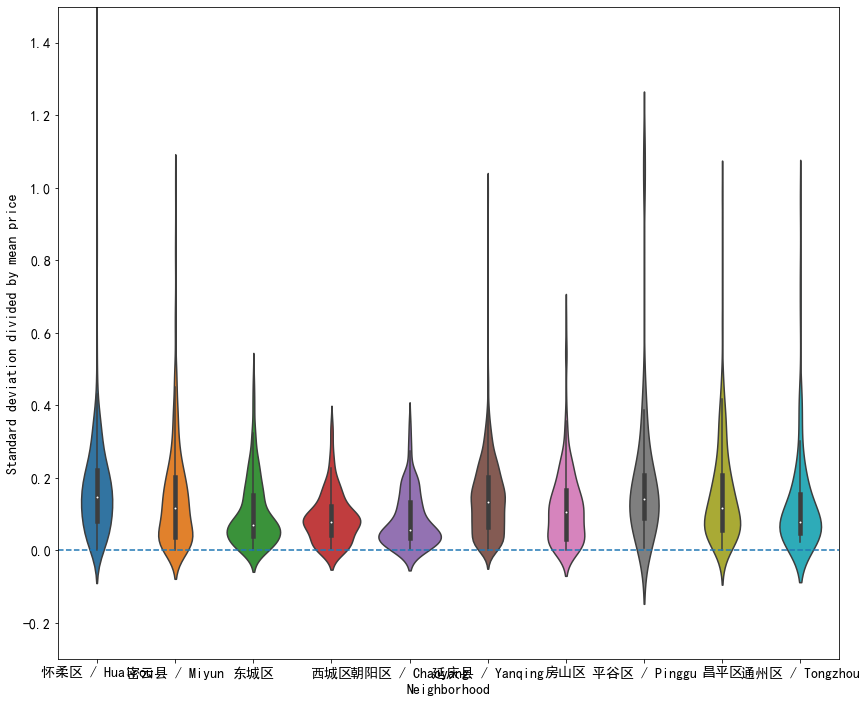

In [333]:
plt.figure(figsize=(14,12))
sns.violinplot(data=df, x='neighborhood',
               y='fractional_std_of_price')
plt.axhline(y=0, linestyle='--')
plt.xlabel('Neighborhood')
plt.ylabel('Standard deviation divided by mean price')
plt.ylim(-0.3, 1.5)
plt.show()

Make another version that explicitly cuts off at zero and is better formatted for presentation:

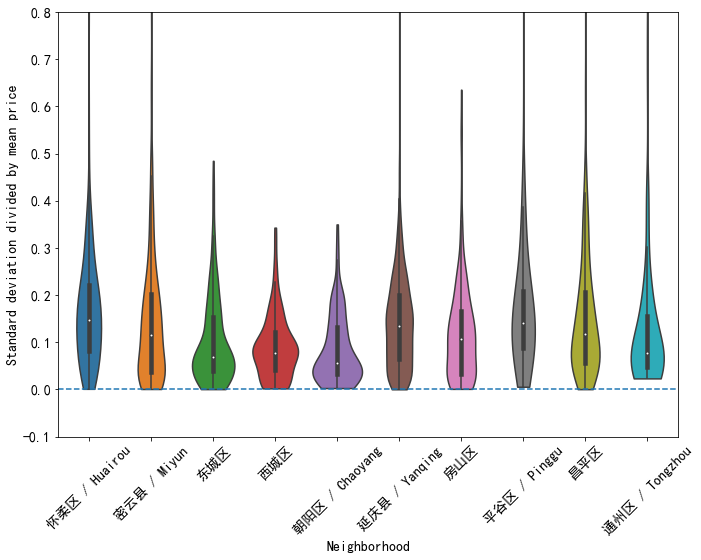

In [336]:
plt.figure(figsize=(10,8))
sns.violinplot(data=df, x='neighborhood',
               y='fractional_std_of_price', cut=0)
plt.axhline(y=0, linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Standard deviation divided by mean price')
plt.ylim(-0.1, 0.8)
plt.tight_layout()
plt.savefig("std_by_nbd.jpg")
plt.show()

This doesn't solve the problem definitively, but there is some useful information here that can give me some insight into which neighborhood(s) to explore further and to (hypothetically) consider my strategy of buying a property in one of these areas and listing it on Airbnb only at certain times of year.

First, note that violin plots are not perfect tools (as noted previously in this notebook): the standard deviation cannot be negative, but the kernel density estimators allow it to be in order to smooth the calculated probability distributions. Also, I checked the above plot with the full $y$ range (not cut off at 1.5) and there is nothing significant that happens above the cutoff.

First, let's look at the medians. Near South Side has a particularly high median; Lincoln Park and Lake View have somewhat high medians; and West Town, Logan Square, Near North Side, Near West Side, and Lower West Side have low medians.

More information can be gleaned from the width of the violins at various heights. West Town, Logan Square, West Side, and Lower West Side are particularly wide near the bottom, again suggesting they would be poor places to implement my strategy. Near South Side is particularly wide at larger heights, as are Lincoln Park and Lake View to a lesser extent. Lake view also has an interesting second peak in its distribution up near 0.7 on the y-axis, meaning that some properties there have particularly high variance in price over the year.

Next, I'll restrict myself to some promising neighborhood, which I take to be Near South Side (which I find the most promising so far). I want to look now at how the price varies over the course of the year, so that I can decide when to plan to leave town and rent my place there on Airbnb.

In [347]:
'朝阳区 / Chaoyang'

0           怀柔区 / Huairou
1           怀柔区 / Huairou
2           怀柔区 / Huairou
3           怀柔区 / Huairou
4           怀柔区 / Huairou
                ...      
1627895    通州区 / Tongzhou
1627896    通州区 / Tongzhou
1627897    通州区 / Tongzhou
1627898    通州区 / Tongzhou
1627899    通州区 / Tongzhou
Name: neighborhood, Length: 1413645, dtype: object


Restrict the dataframe to the Near South Side neighborhood, and group by the day:

In [348]:
# df = price_by_nbd.loc[price_by_nbd['neighborhood']==
#                                 'Near South Side'].groupby(by='day')

                               
df = price_by_nbd.loc[price_by_nbd['neighborhood']==
                                 '朝阳区 / Chaoyang'].groupby(by='day')

Make dataframes with the median, mean, and standard deviation of the price for each day (over all listings) for this neighborhood:

In [349]:
medians = df.median()[['price']].rename(columns={'price':'median_price'})
means = df.mean()[['price']].rename(columns={'price':'mean_price'})
std = df.std()[['price']].rename(columns={'price':'std_price'})

Join these into one dataframe:

In [350]:
near_south_side = pd.concat([medians, means, std, df.size()], axis=1)

Rename the index (which represents the count of listings for each day) to 'count':

In [351]:
near_south_side.rename(columns={0:'count'}, inplace=True)

Make a column for the standard error of the mean:

In [352]:
near_south_side['std_err_of_mean'] = near_south_side['std_price']/np.sqrt(near_south_side['count'])


For each day, I have calculated the mean price of listings in the Near South Side neighborhood and put this in the 'mean_price' column. I've also calculated the standard error of the mean for each day (standard deviation divided by square root of number of observations) and put that in the 'std_err_of_mean' column.

Plot the mean price versus the day for the Near South Side neighborhood:

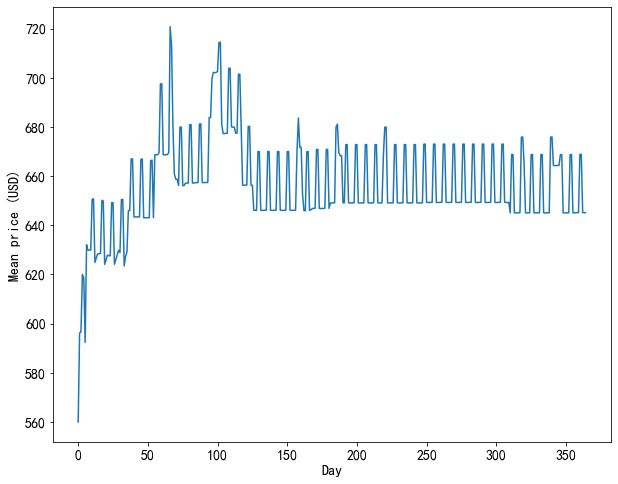

In [353]:
plt.figure(figsize=(10,8))
x = near_south_side.index
y = near_south_side['mean_price']
plt.plot(x, y)
plt.xlabel('Day')
plt.ylabel('Mean price (USD)')
plt.show()

The changes in mean price over time appear to be substantial. Certainly there's the obvious weekly fluctuation: the price is higher on weekends than on weekdays. But there are also several weekends that stand out from their neighbors with higher prices, and there appears to be a boost in general around day 220.

To see if these trends are a mirage, I'll take a look at the standard errors now (in red in the following plot):

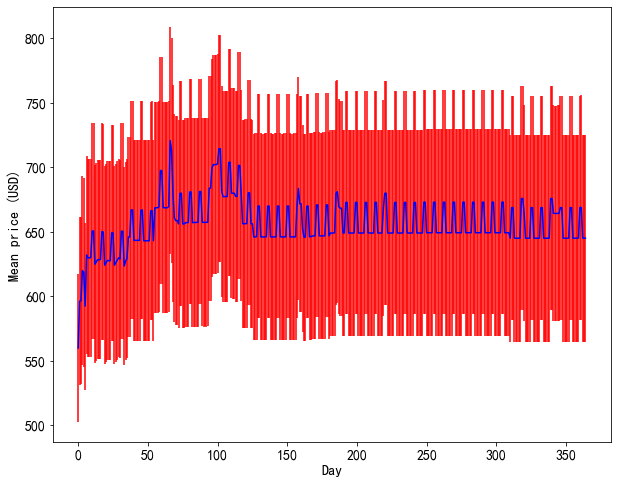

In [354]:
plt.figure(figsize=(10,8))
x = near_south_side.index
y = near_south_side['mean_price']
yerr = near_south_side['std_err_of_mean']
plt.errorbar(x, y, yerr=yerr, color='b', ecolor='r')
plt.xlabel('Day')
plt.ylabel('Mean price (USD)')
plt.show()

There are some weekends that are higher than than their neighbors, outside the error bars: the ones around days 40, 75, and possibly 330 stand out. The high prices on weekdays preceeding that last peak is interesting; while not completely out of error bars relative to the neighboring weeks, it might be worth listing the property at a higher price that week. The upward trend on weekends from day 100 to day 220 or so is notable. The intra-week price variation is smaller for several weeks after the day 75 peak, meaning that period is perhaps not as popular for weekend travel to Chicago (indeed, that's during the dead of winter). The jump around day 230 is also notable: closer inspection reveals that the error bars for the weekends after that generally do not overlap the error bars for weekends before that (this this somewhat obfuscated by the fact that all the error bars are bigger after day 230, making it harder to distinguish those for weekends from those for weekdays).

Isolate and plot (with error bars) the region after Day 220:

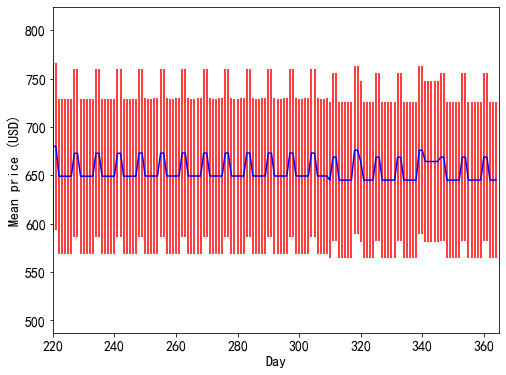

In [355]:
plt.figure(figsize=(8,6))
x = near_south_side.index
y = near_south_side['mean_price']
yerr = near_south_side['std_err_of_mean']
plt.errorbar(x, y, yerr=yerr, color='b', ecolor='r')
plt.xlim(220, 365)
plt.xlabel('Day')
plt.ylabel('Mean price (USD)')
plt.show()

Yep, the jump in mean price after day 230 is very real.

Now I want to zoom in on some of the peaks to get a better handle on the dates:

Find the indices of some local maxima I'm interested in:

In [356]:
to_mark = []
to_mark.append(near_south_side['mean_price'][30:60].idxmax())
to_mark.append(near_south_side['mean_price'][60:80].idxmax())
to_mark.append(near_south_side['mean_price'][225:235].idxmax())
to_mark.append(near_south_side['mean_price'][320:350].idxmax())

And plot these local maxima as red dots on the plot of mean price vs. day:

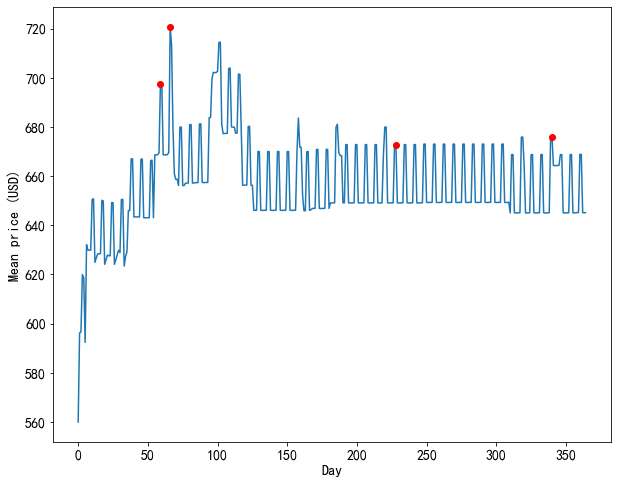

In [357]:
plt.figure(figsize=(10,8))
x = near_south_side.index
y = near_south_side['mean_price']
plt.plot(x, y)
plt.plot(to_mark, y[to_mark], 'ro')
plt.rcParams['font.size'] = 14
plt.xlabel('Day')
plt.ylabel('Mean price (USD)')
plt.savefig('nss_mean_price.jpg')
plt.show()

Print the day of the week and date for each of these local maxima:

In [358]:
for day in to_mark:
    print(day_to_date(day))

Thursday, 2021-12-16
Thursday, 2021-12-23
Friday, 2022-06-03
Friday, 2022-09-23


Clearly hosts (and Airbnb's smart pricing algorithm, for hosts who choose to use it) anticipate high demand over Thanksgiving and New Years Eve weekends. After New Years there's a slump, with prices going up slowly and steadily in the next few months. The season of high prices is the summer through early fall, and apparently the official start of this for pricing purposes is the June 4 weekend. I'm less sure what is going on on 9-17 and the week leading up to it, but my best guess is that college students are coming back to town and their families need places to stay.

I'd be remiss if I didn't note something odd about this plot. The last day plotted is October 17 (2022) and the first is October 18 (2021), only one day apart in the calendar year - so why are the prices so different? One would expect there to be yearly periodicity in price, perhaps with a slight upward trend if economic growth (and/or inflation) continues. These are not normal times, though. While Chicago was not hit as hard as many areas, the Delta variant has likely led to reduced travel, and hosts have adjusted prices accordingly; next year, they apparently anticipate demand returning to more normal levels.

## Deployment

What are my actionable insights from the above analysis?

The Near South Side neighborhood offers excellent moneymaking opportunities for hosts who anticipate demand well and adjust their prices accordingly. If I were interested in buying or renting a place in Chicago that I would live in and list on Airbnb from time to time, I would likely buy in that neighborhood.

Due to the large price increases on weekends there, I would generally consider listing my place on weekends but not during the week (to avoid the inconvenience of guests and/or finding another place to stay while I'm doing my day job during the week). I would definitely list it at high prices in the few days around Thanksgiving, New Years Eve, and mid-September. I probably would not list it in January or February, when it's especially cold and demand is low. I would certainly list it often on weekends at high prices starting in June and going through October or so.

# Question 3: Learning about the neighborhoods

This last part is a bit lighter. I've only been to Chicago a few times, and I don't know a lot about the different neighborhoods. What can I find out about the character of the neighborhoods from the Airbnb hosts' descriptions in their listings? The relevant column in `listings` is 'neighborhood_overview'.

## Data preparation

Make a dataframe with just the neighborhood and neighborhood description for each listing:

In [359]:
nbd_character = listings[['neighbourhood_cleansed', 'neighborhood_overview']].copy()

Drop any rows that have `NA` in either field:

In [360]:
nbd_character.dropna(how='any', inplace=True)

Rename the columns to have shorter and more idiomatic names:

In [361]:
nbd_character.rename(columns={'neighbourhood_cleansed':'neighborhood',
                              'neighborhood_overview':'description'}, inplace=True)

I'll restrict to the 10 neighborhoods with the most listings for this part. Find those top ten neighborhoods:

In [362]:
top_10_nbds = nbd_character['neighborhood'].value_counts()[:10].index

In [363]:
top_10_nbds

Index(['怀柔区 / Huairou', '延庆县 / Yanqing', '密云县 / Miyun', '东城区', '房山区', '昌平区',
       '平谷区 / Pinggu', '通州区 / Tongzhou', '朝阳区 / Chaoyang', '西城区'],
      dtype='object')

Restrict the dataframe to those ten neighborhoods:

In [364]:
nbd_character = nbd_character.loc[nbd_character['neighborhood'].isin(top_10_nbds)]

In [365]:
nbd_character

,neighborhood,description
0,怀柔区 / Huairou,Located in a small village at the base of the ...
1,东城区,The neighborhood is very safe and full of loca...
3,密云县 / Miyun,唐家寨
6,怀柔区 / Huairou,"small mountain village, quite a lot old villag..."
7,怀柔区 / Huairou,"怀柔范崎路上,过APEC会议景区约6公里处｡"
...,...,...
4478,通州区 / Tongzhou,周边基础设施完善，有儿童玩耍区、成人活动区。小区内风景宜人，湖水和小区内景观交相辉映，夏日赏...
4479,通州区 / Tongzhou,周边基础设施完善，有儿童玩耍区、成人活动区。小区内风景宜人，湖水和小区内景观交相辉映，夏日赏...
4480,通州区 / Tongzhou,周边基础设施完善，有儿童玩耍区、成人活动区。小区内风景宜人，湖水和小区内景观交相辉映，夏日赏...
4481,通州区 / Tongzhou,周边基础设施完善，有儿童玩耍区、成人活动区。小区内风景宜人，湖水和小区内景观交相辉映，夏日赏...


For each neighborhood, I will combine all the descriptions into one string, with spaces in between the joined individual descriptions.

Group the dataframe by neighborhood and apply this string join operation to get the desired dataframe:

In [366]:
descriptions = pd.DataFrame(nbd_character.groupby(by='neighborhood')
                            ['description'].apply(' '.join))

In [367]:
descriptions

,description
neighborhood,
东城区,The neighborhood is very safe and full of loca...
密云县 / Miyun,唐家寨 小区内设施齐全，空气清新，可晨跑，看观山八景。周边古北水镇景区日游，逛小吃街。夜间无...
平谷区 / Pinggu,【500米】著名的天云山风景区、千佛崖风景区…飞龙谷风景区<br />【1千米】平谷著名十六...
延庆县 / Yanqing,FAQ<br /><br /><br />1) what is the distance f...
怀柔区 / Huairou,Located in a small village at the base of the ...
房山区,空气清新 北京市房山区韩村河镇西周各庄村西侧农场院内。 别墅旁边的景区有很多可以玩的，蹦极，...
昌平区,we have bus No 21 connect to the subway statio...
朝阳区 / Chaoyang,"酒店位于霄云路上,霄云路是北京著名的小吃一条街。您可以在这里品尝到来自于台湾、日本、韩国、德..."
西城区,本酒店地处老北京的市中心西四北二条胡同10号院，是北京一类保护区。西四二条始建于明代的胡同。...


As a quick check, figure out how many characters are in the combined descriptions of the Lake View neighborhood in this dataframe:

In [369]:
# len(descriptions.loc['Lake View', 'description'])
len(descriptions.loc['朝阳区 / Chaoyang', 'description'])


22083

That's a lot of characters, which makes sense.

## Evalutation (analysis and visualization)

I think a world cloud is a good tool for figuring out at a glance what some of the important characteristics of a neighborhood are. I'll use WordCloud for Python, open source software by Andreas Mueller that's documented [here](https://amueller.github.io/word_cloud/). I am using Version 1.8.1.

Import the necessary pieces from the package:

In [370]:
from wordcloud import WordCloud, STOPWORDS

ModuleNotFoundError: No module named 'wordcloud'

The WordCloud package comes with a bunch of stopwords (e.g. 'a', 'the', 'that', etc.) that I won't want in my word clouds. There are additional context-specific words I'll want to exclude as well, such as the name of the neighborhoods in question, as well as words like 'city' and 'neighborhood'; I've added these to the `stopwords` set below (some of them as I saw them in the word clouds and realized I didn't want them).

Create a set of stopwords and update it with the names of the neighborhoods and other common but uninformative words (or formatting characters) that appear in the descriptions:

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(list(top_10_nbds) + ['Lakeview'])
stopwords.update(['View', 'Lincoln', 'Park', 'Logan', 'Square'])
stopwords.update(['Near', 'North', 'South', 'West', 'Side', 'Town'])
stopwords.update(['home', 'city', 'neighborhood', 'Chicago', 'apartment', 'br', 's'])
stopwords.update(['one', 'place', 'km'])

Write a function that takes the name of a neighborhood and displays the word cloud, optionally saving it as a JPG file:

In [ ]:
def make_wordcloud(neighborhood, save=False):
    ''' INPUTS: neighborhood - the name of the neighborhood for which a word cloud
                should be made.
                save - a boolean that determines whether to save the word cloud
                as a jpg file.
        OUTPUTS: none. The wordcloud is plotted and it is saved if save=True.
    '''
    text = descriptions.loc[neighborhood, 'description']
    wordcloud = WordCloud(max_font_size=40, max_words=50, background_color='white',
                          stopwords=stopwords).generate(text)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if save:
        plt.savefig(f'{neighborhood}.jpg')
    plt.show()

To spare the reader too much repitition, I'll restrict to some of the neighborhoods I'm especially interested in.

Make a word cloud for the Lake View neighborhood and save it:

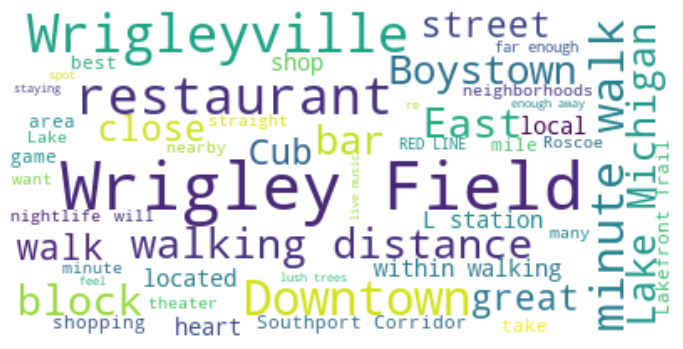

In [ ]:
make_wordcloud('Lake View', save=True)

From this I'd guess that Wrigley Field, Wrigleyville, and Boystown are in the Lake View neighborhood. Downtown is also close by, the Red Line runs through it, and it borders Lake Michigan. Walking figures prominently in this cloud, so I'm guessing there are many things to do within walking distance, such as restaurants and games at Wrigley Field. It appears there's also a thriving bar and nightlife scene.

Make a word cloud for the Lincoln Park neighborhood and save it:

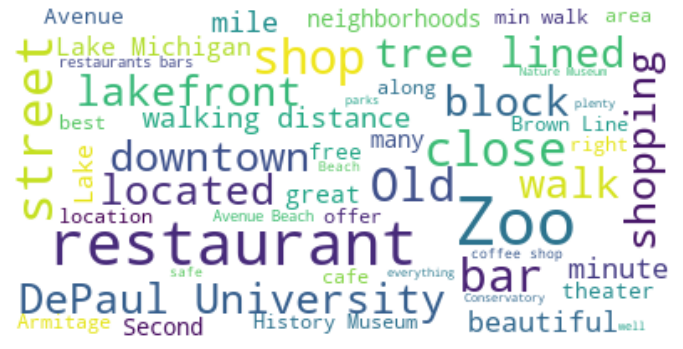

In [ ]:
make_wordcloud('Lincoln Park', save=True)

It looks to me like Lake Michigan, the zoo, DePaul University, the nature and history museums, a conservatory, and the downtown area are near or in the Lincoln Park neighborhood. With regard to getting around, I'd guess many things are walking distance away and the Brown line passes through it. I'd guess that it's a relatively old neighborhood with a lot of trees, but there's also a lot of shopping to do close by, as well as cafes, restaurants, and bars aplenty. I've been to Lincoln Park, so I know these suggestions from the wordcloud above are pretty accurate.

Make a word cloud for the Logan Square neighborhood and save it:

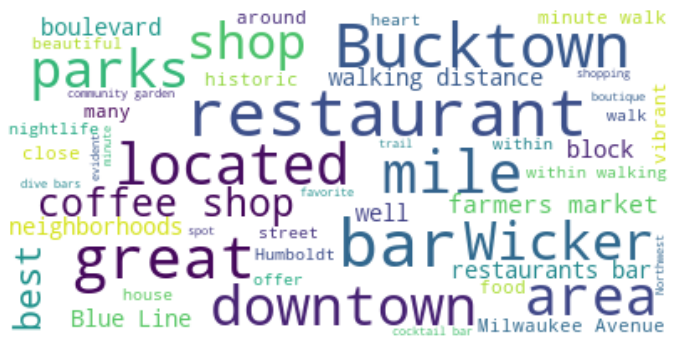

In [ ]:
make_wordcloud('Logan Square', save=True)

It looks like Logan Square is close to Bucktown and Wicker Park (or they're located in it), and there's a big restaurant scene (I'd guess bigger than in Lincoln Park, since the word 'restaurant' is much bigger in this wordcloud). It's seen as a vibrant area with many parks, and there are lots of places to shop and many things to do within walking distance. I'd guess the Blue Line runs through it and its close to downtown.

I've never been to Logan Square, so this was useful for helping me get a feel for what's around there.

Make a word cloud for the Near South Side neighborhood and save it:

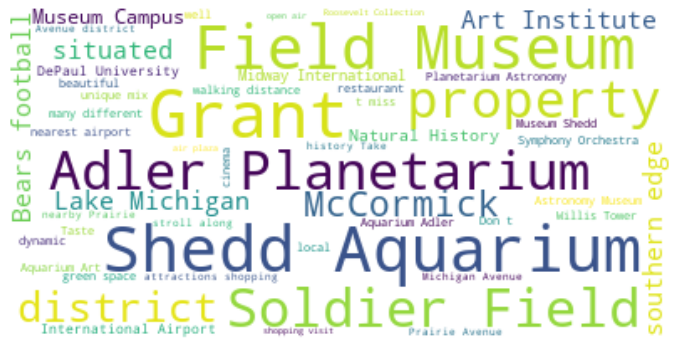

In [ ]:
make_wordcloud('Near South Side', save=True)

No wonder prices are a bit higher in this area, particularly during tourist times. The Field Museum, Adler Planetarium, Shedd Aquarium, Grant Park, Natural History Museum, and Art Institute are all in or near the Near South Side neighborhood. The McCormick Convention Center is nearby, which may also explain why the variation in prices with time is large here (demand increases sharply when there's a convention in town). The Bears play at Soldier Field there, which may also generate more demand on weekends.

## Deployment

The `make_wordcloud()` function above is useful for anyone who wants to do this analysis on a different neighborhood. The only required argument to that function is a string with the neighborhood's name; the word cloud is also saved as a JPG image if `save=True`. This can be deployed on any of the other neighborhoods that have at least one listing with a non-null `neighborhood_overview` field. 